In [1]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

In [3]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

In [4]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Adesao'

porte_operadora = 'Pequeno'

tipo_modalidade = 'Cooperativa Médica'

## Leitura dos dados

In [5]:
path = f'D:/TCC/TCC/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

ans['ano'] = ans['ano'].astype('str')

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

ans = ans[(ans.ano > '2017') & (ans.ano < '2022')]

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.head()

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/03/2018,2018Q1,791860.200,0.000,722.000,0.0,0.0
1,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2018,2018Q2,769499.340,0.000,731.000,0.0,0.0
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2018,2018Q3,846654.020,0.000,774.000,0.0,0.0
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/12/2018,2018Q4,903017.550,0.000,787.000,0.0,0.0
4,2019,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2019,2019Q2,1801080.840,0.000,775.000,0.0,0.0


In [6]:
ans_filt_cont_mod = ans_filt[ (ans_filt['contratacao'] == tipo_contratacao) & 
                              (ans_filt['modalidade'] == tipo_modalidade) &
                              (ans_filt['port_ops'] == porte_operadora)].reset_index(drop=True)

ans_filt_cont_mod = ans_filt_cont_mod[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_cont_mod.head()


,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,trimestre,receita,despesa,benef
0,2018,301060,UNIMED ITUIUTABA COOPERATIVA TRABALHO MÉDICO LTDA.,Cooperativa Médica,Pequeno,P,Adesao,Pre-estabelecido,2018Q1,1177721.040,449595.640,1021.000
1,2018,301060,UNIMED ITUIUTABA COOPERATIVA TRABALHO MÉDICO LTDA.,Cooperativa Médica,Pequeno,P,Adesao,Pre-estabelecido,2018Q2,1184356.930,663144.760,1008.000
2,2018,301060,UNIMED ITUIUTABA COOPERATIVA TRABALHO MÉDICO LTDA.,Cooperativa Médica,Pequeno,P,Adesao,Pre-estabelecido,2018Q3,1180727.880,568360.530,1000.000
3,2018,301060,UNIMED ITUIUTABA COOPERATIVA TRABALHO MÉDICO LTDA.,Cooperativa Médica,Pequeno,P,Adesao,Pre-estabelecido,2018Q4,1234356.150,61217.930,994.000
4,2019,301060,UNIMED ITUIUTABA COOPERATIVA TRABALHO MÉDICO LTDA.,Cooperativa Médica,Pequeno,P,Adesao,Pre-estabelecido,2019Q1,1276805.170,935637.470,995.000


In [7]:
ans_filt_cont_mod.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

receita  despesa
ano  cd_ops razao_social                                       trimestre                  
2018 301060 UNIMED ITUIUTABA COOPERATIVA TRABALHO MÉDICO LTDA. 2018Q1       1.180    0.450
                                                               2018Q2       1.180    0.660
                                                               2018Q3       1.180    0.570
                                                               2018Q4       1.230    0.060
     301124 UNIMED GURUPI COOPERATIVA DE TRABALHO MÉDICO       2018Q1       2.090    1.400

In [8]:
ans_filt_cont_mod_agrup = ans_filt_cont_mod.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                             'despesa':lambda x: sum_million(x),
                                                                                             'benef': 'sum',
                                                                                             'cd_ops':lambda x: x.nunique()})

ans_filt_cont_mod_agrup['pct_despesa'] = ans_filt_cont_mod_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_cont_mod_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[(ans_filt_cont_mod_agrup.trimestre > '2017Q4') & (ans_filt_cont_mod_agrup.trimestre < '2022Q1')]

ans_filt_cont_mod_agrup[['n_ops','benef']] = ans_filt_cont_mod_agrup[['n_ops','benef']].astype('int')

#ans_filt_cont_mod_agrup['trimestre'] = pd.PeriodIndex(ans_filt_cont_mod_agrup['trimestre'], freq="Q")

ans_filt_cont_mod_agrup.set_index('trimestre', inplace=True)

ans_filt_cont_mod_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,201.990,135.530,168361,90,67.100
2018Q2,206.860,150.840,167869,92,72.920
2018Q3,200.730,140.160,165406,92,69.830
2018Q4,227.940,124.940,166328,93,54.810
2019Q1,190.250,120.840,170386,93,63.520
2019Q2,187.690,147.020,179692,95,78.330
2019Q3,183.860,155.060,189999,96,84.340
2019Q4,205.890,158.950,194589,96,77.200
2020Q1,219.480,132.240,188464,96,60.250


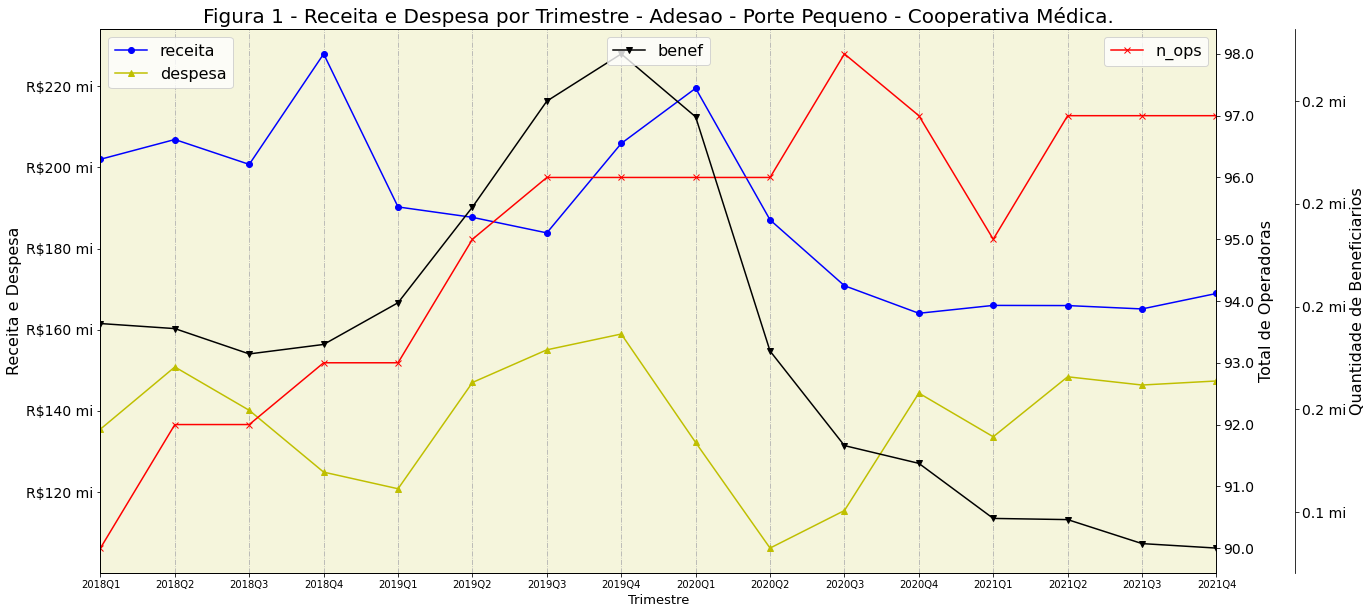

In [9]:
df_plot = ans_filt_cont_mod_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesao - Porte Pequeno - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1000000) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [10]:
#Cria o rankin das operadoras com maior receita e despesa
ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                         'despesa':lambda x: sum_million(x),
                                                                                                         'benef': 'sum'}).reset_index(drop=True)

ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod_agrup_ops.sort_values(['benef'],ascending = False).groupby('trimestre').head(100).reset_index()

#ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','benef'], ascending=[True,False], inplace=True)

ans_filt_cont_mod_agrup_ops.head()

,index,ano,cd_ops,trimestre,receita,despesa,benef
0,478,2019,324213,2019Q4,41.440,10.730,38624.000
1,477,2019,324213,2019Q3,34.850,9.420,35700.000
2,853,2020,324213,2020Q1,56.400,7.250,32323.000
3,476,2019,324213,2019Q2,32.140,6.880,25485.000
4,103,2018,324213,2018Q1,46.620,25.210,21292.000


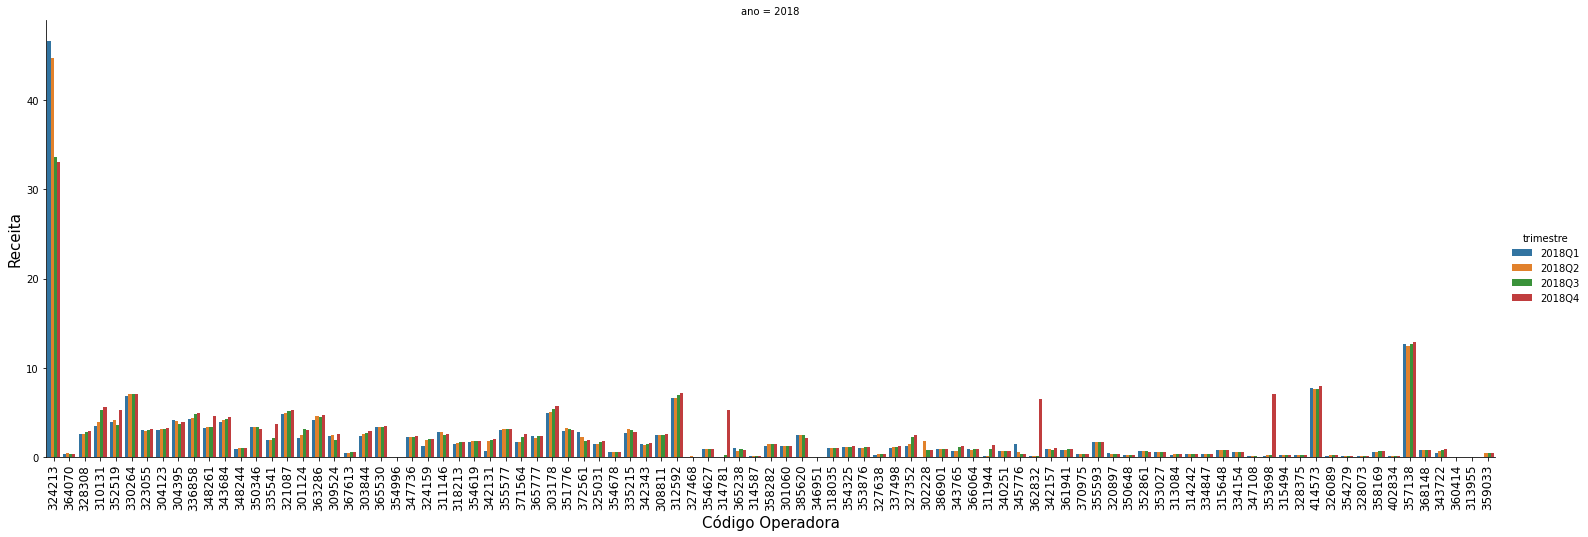

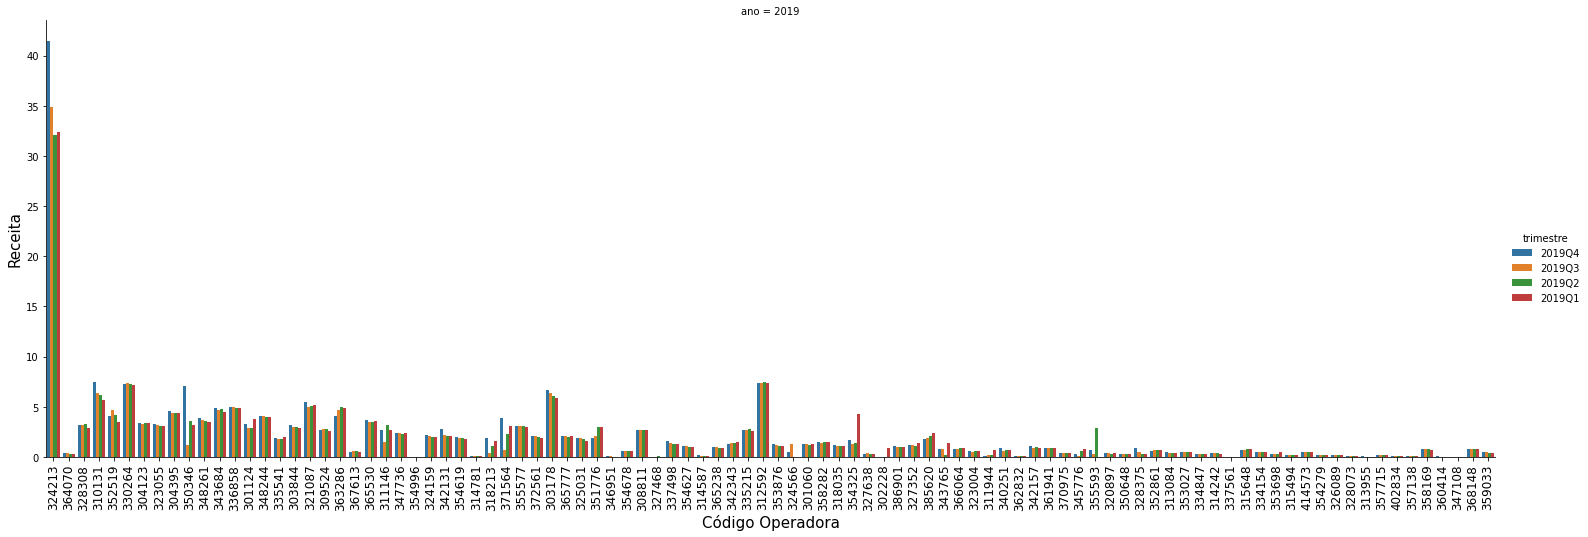

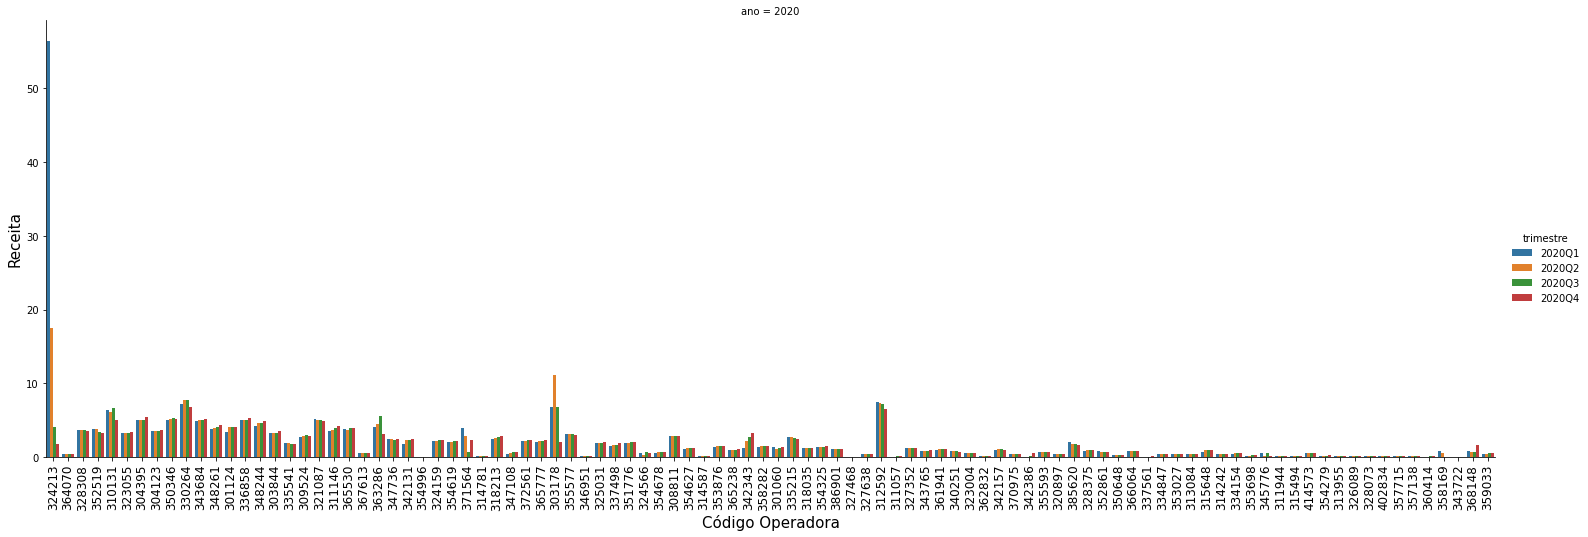

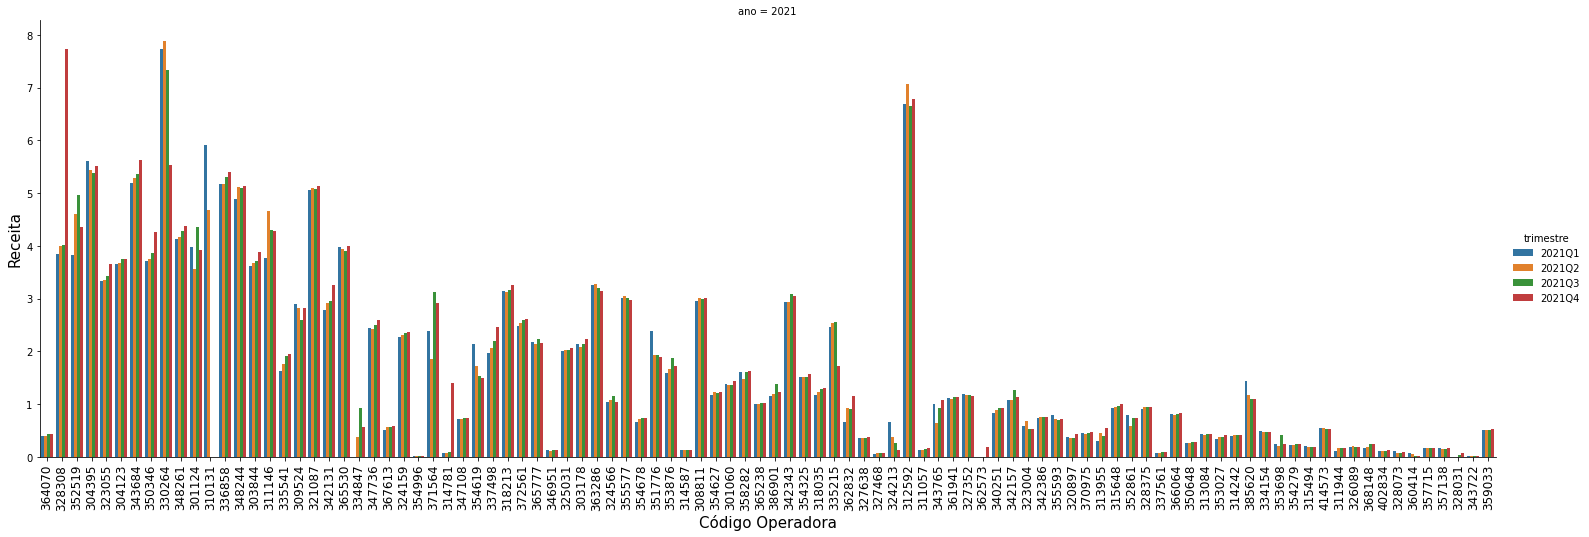

In [11]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

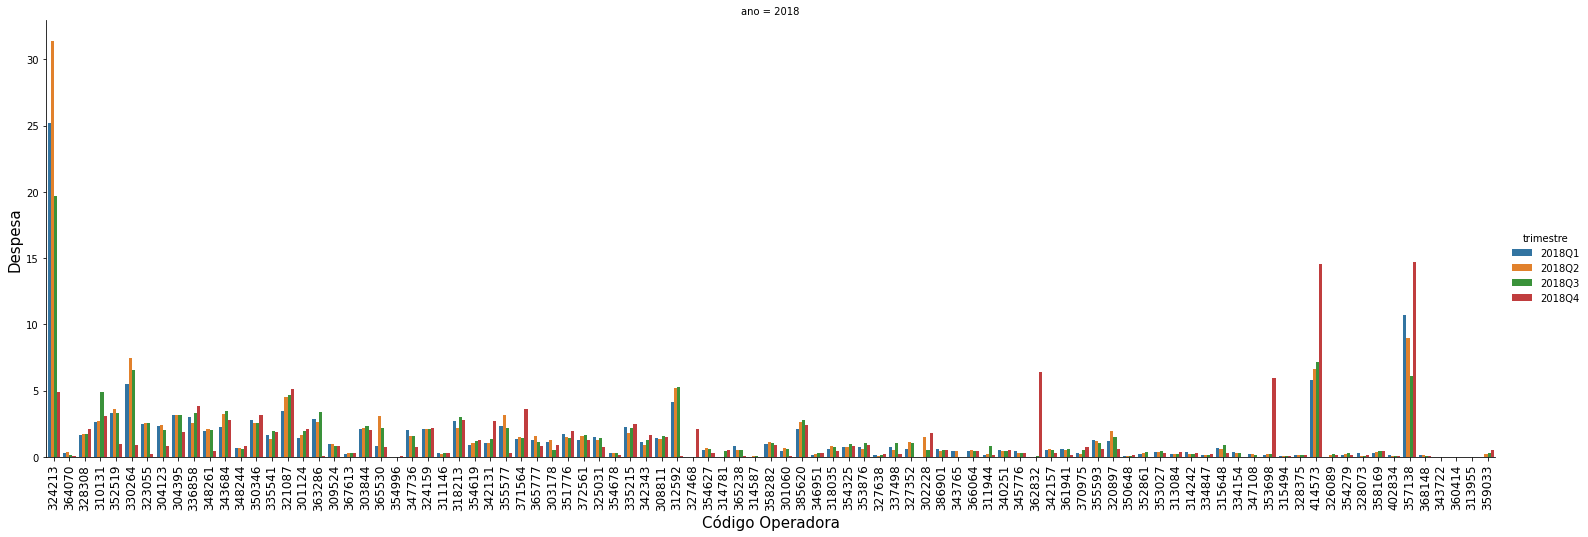

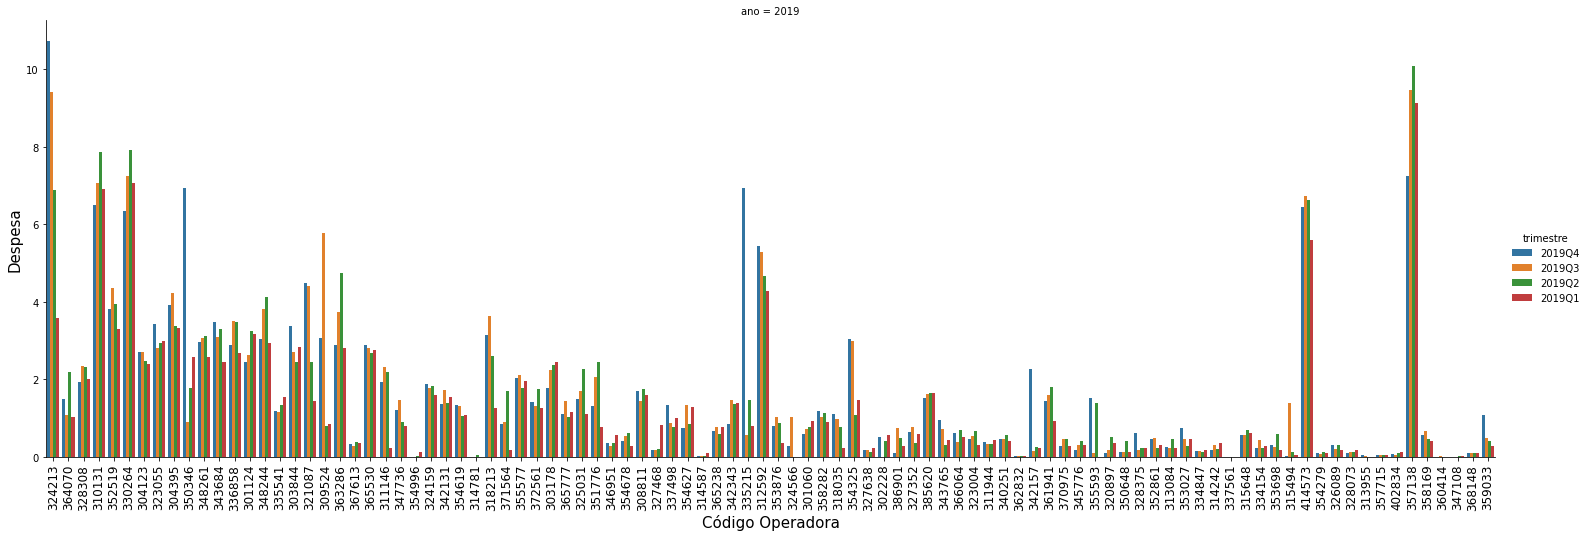

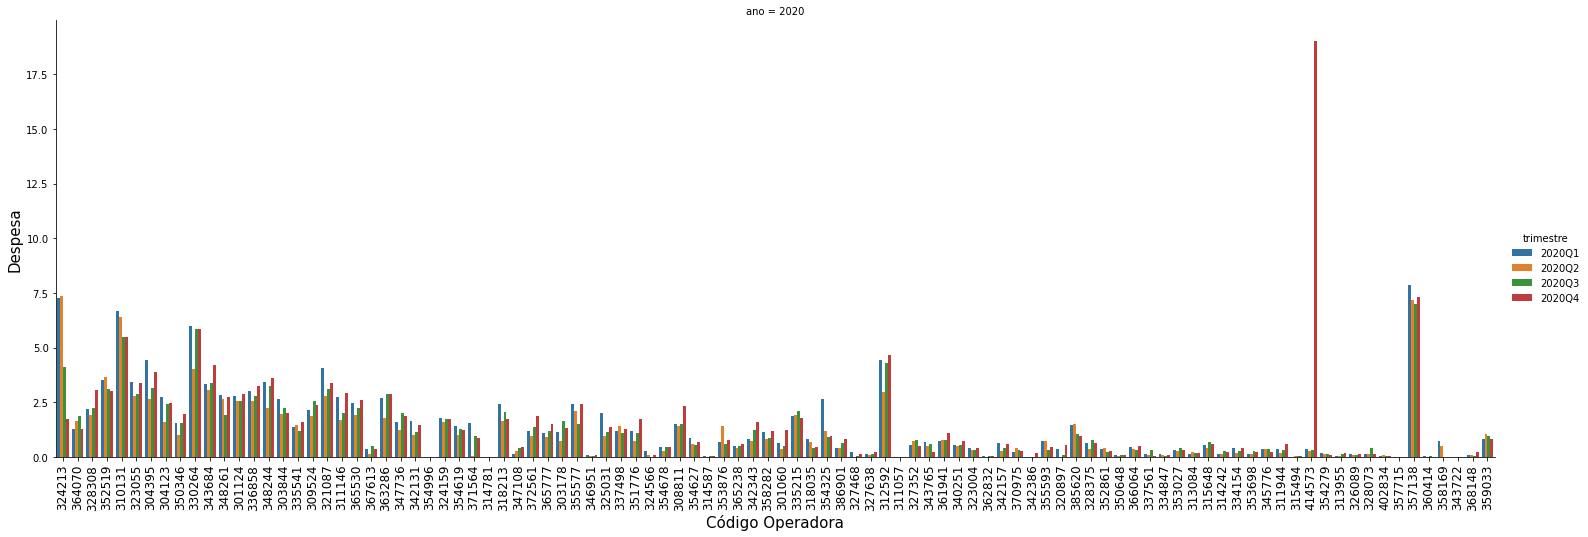

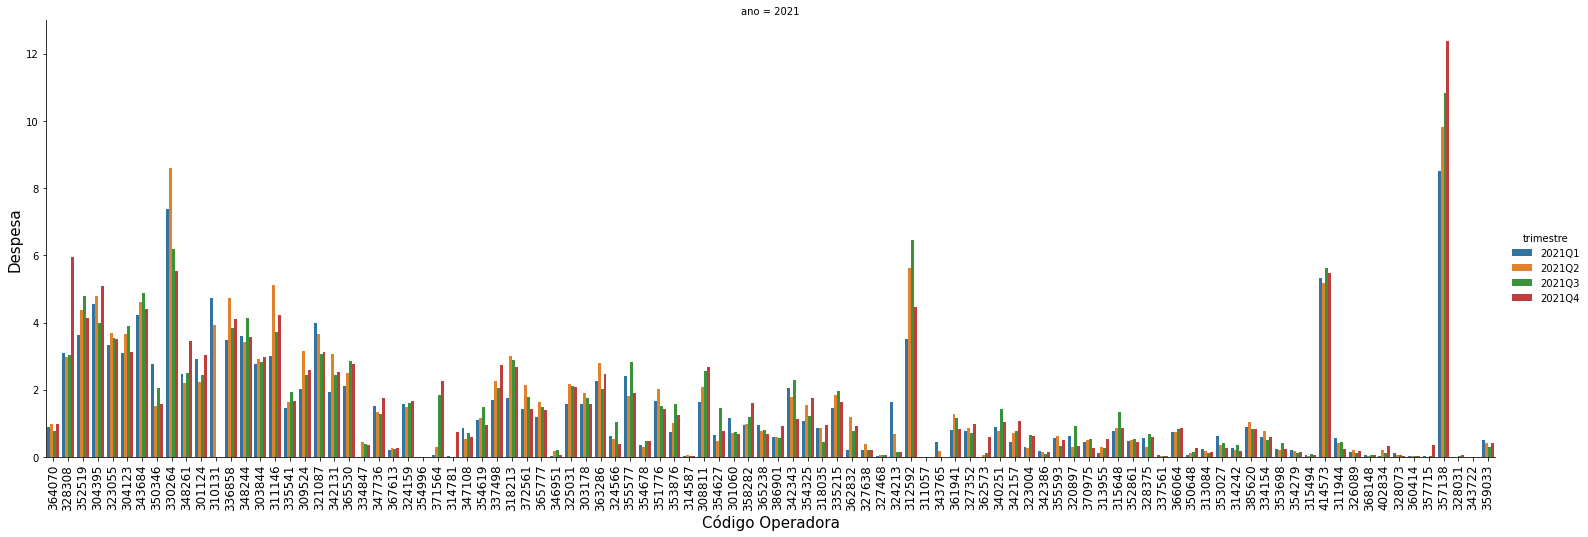

In [12]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Limpeza e Tratamento de Dados

In [13]:
ans_alterada1 = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                             'despesa':'sum'})

ans_alterada1 = ans_alterada1[(ans_alterada1['ano']>'2017') & (ans_alterada1['ano']<'2022')] #Filtra anos de 2018 até 2021

ans_alterada = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita != 0) & (ans_alterada1.despesa == 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa != 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa == 0)].index)

display(ans_alterada1.head())

,ano,cd_ops,trimestre,receita,despesa
0,2018,301060,2018Q1,1177721.040,449595.640
1,2018,301060,2018Q2,1184356.930,663144.760
2,2018,301060,2018Q3,1180727.880,568360.530
3,2018,301060,2018Q4,1234356.150,61217.930
4,2018,301124,2018Q1,2092732.850,1396791.320


In [14]:
ans_alterada2 = ans_alterada1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))

#ans_alterada2.n_trimestre.unique()

ans_alterada2.head()

,ano,cd_ops,n_trimestre
0,2018,301060,4
1,2018,301124,4
2,2018,302228,3
3,2018,303178,4
4,2018,303844,4


In [15]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
ans_alterada_complete = ans_alterada2[ans_alterada2['n_trimestre']==4].reset_index(drop=True)
ans_alterada_complete = ans_alterada_complete[['ano','cd_ops']]
display(ans_alterada_complete.head())

complete_ops_list = ans_alterada_complete['cd_ops'].to_numpy()

,ano,cd_ops
0,2018,301060
1,2018,301124
2,2018,303178
3,2018,303844
4,2018,304123


In [16]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
ans_alterada_imcomplete = ans_alterada2[ans_alterada2['n_trimestre']!=4].reset_index(drop=True)
ans_alterada_imcomplete = ans_alterada_imcomplete[['ano','cd_ops']]
display(ans_alterada_imcomplete.head())

imcomplete_ops_list = ans_alterada_imcomplete['cd_ops'].to_numpy()

,ano,cd_ops
0,2018,302228
1,2018,359033
2,2018,360414
3,2019,302228
4,2019,324566


In [17]:
diff_list = np.setdiff1d(complete_ops_list,imcomplete_ops_list)

ans_alterada_complete = ans_alterada_complete[ans_alterada_complete["cd_ops"].isin(diff_list)]

ans_alterada_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 370
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     348 non-null    period[A-DEC]
 1   cd_ops  348 non-null    object       
dtypes: object(1), period[A-DEC](1)
memory usage: 8.2+ KB


In [18]:
#Filtra as operadoras com lançamentos completos
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada3 =  ans_alterada1[i1.isin(i2)]

#diops_tcc_analise3[diops_tcc_analise3['receita']==0]

display(ans_alterada3.head())

#Verificação da filtragem
ans_alterada3_vef = ans_alterada3[(ans_alterada3['ano']>'2017') & (ans_alterada3['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada3_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,301060,2018Q1,1177721.040,449595.640
1,2018,301060,2018Q2,1184356.930,663144.760
2,2018,301060,2018Q3,1180727.880,568360.530
3,2018,301060,2018Q4,1234356.150,61217.930
4,2018,301124,2018Q1,2092732.850,1396791.320


array([4], dtype=int64)

In [19]:
#Cálculo do percentual de crescimento entre os trimestres
ans_alterada3['ref1'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str))

ans_alterada3['ref2'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str)+
                            ans_alterada3['trimestre'].map(str))

ans_alterada3[['receita_shifted','despesa_shifted']] = ans_alterada3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

ans_alterada3['pct_tri_receita'] = ((ans_alterada3['receita'] / ans_alterada3['receita_shifted'])) 
ans_alterada3['pct_tri_despesa'] = ((ans_alterada3['despesa'] / ans_alterada3['despesa_shifted'])) 
 
ans_alterada3 = ans_alterada3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

ans_alterada3.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa
0,2018,301060,2018Q1,1177721.040,0.000,0.000,449595.640,0.000,0.000
1,2018,301060,2018Q2,1184356.930,1177721.040,1.006,663144.760,449595.640,1.475
2,2018,301060,2018Q3,1180727.880,1184356.930,0.997,568360.530,663144.760,0.857
3,2018,301060,2018Q4,1234356.150,1180727.880,1.045,61217.930,568360.530,0.108
4,2018,301124,2018Q1,2092732.850,0.000,0.000,1396791.320,0.000,0.000


In [20]:
stats_ans_alterada = pd.DataFrame(ans_alterada3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_ans_alterada = stats_ans_alterada.reset_index(level=[0,1])

stats_ans_alterada.columns = ['_'.join(col) for col in stats_ans_alterada.columns.values]

stats_ans_alterada = stats_ans_alterada[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_ans_alterada.rename(columns = {'ano_':'ano',
                                     'trimestre_':'trimestre',
                                     'pct_tri_receita_25%':'pct_tri_receita_25',
                                     'pct_tri_receita_75%':'pct_tri_receita_75',
                                     'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                     'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

stats_ans_alterada

,ano,trimestre,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,2018Q1,0.000,0.000,0.000,0.000
1,2018,2018Q2,0.991,1.064,0.840,1.255
2,2018,2018Q3,0.991,1.076,0.889,1.183
3,2018,2018Q4,0.994,1.065,0.364,1.146
4,2019,2019Q1,0.000,0.000,0.000,0.000
5,2019,2019Q2,0.961,1.041,0.867,1.648
6,2019,2019Q3,0.979,1.046,0.792,1.263
7,2019,2019Q4,0.998,1.091,0.817,1.165
8,2020,2020Q1,0.000,0.000,0.000,0.000
9,2020,2020Q2,0.975,1.064,0.608,0.927


In [21]:
ans_alterada4 =  pd.merge(ans_alterada3, stats_ans_alterada, how = 'left', on = ['ano','trimestre'])

ans_alterada4 = ans_alterada4[( (ans_alterada4['pct_tri_receita'] >= ans_alterada4['pct_tri_receita_25']) & 
                                (ans_alterada4['pct_tri_receita'] <= ans_alterada4['pct_tri_receita_75'])) &
                                ((ans_alterada4['pct_tri_despesa'] >= ans_alterada4['pct_tri_despesa_25']) & 
                                (ans_alterada4['pct_tri_despesa'] <= ans_alterada4['pct_tri_despesa_75']))]

ans_alterada4.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,301060,2018Q1,1177721.040,0.000,0.000,449595.640,0.000,0.000,0.000,0.000,0.000,0.000
4,2018,301124,2018Q1,2092732.850,0.000,0.000,1396791.320,0.000,0.000,0.000,0.000,0.000,0.000
8,2018,303178,2018Q1,4939932.550,0.000,0.000,1129738.840,0.000,0.000,0.000,0.000,0.000,0.000
9,2018,303178,2018Q2,5076549.660,4939932.550,1.028,1296715.250,1129738.840,1.148,0.991,1.064,0.840,1.255
12,2018,303844,2018Q1,2392554.390,0.000,0.000,2115790.300,0.000,0.000,0.000,0.000,0.000,0.000


In [22]:
stats_ans_alterada2 = ans_alterada4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_ans_alterada2 = stats_ans_alterada2.reset_index(level=[0,1])

stats_ans_alterada2.columns = ['_'.join(col) for col in stats_ans_alterada2.columns.values]

stats_ans_alterada2 = stats_ans_alterada2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_ans_alterada2.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_tri_receita_50%':'pct_tri_receita_50',
                                      'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,0.000,0.000
1,2018,2018Q2,1.028,1.019
2,2018,2018Q3,1.020,1.046
3,2018,2018Q4,1.024,0.789
4,2019,2019Q1,0.000,0.000
5,2019,2019Q2,1.005,1.111
6,2019,2019Q3,1.006,0.986
7,2019,2019Q4,1.016,0.999
8,2020,2020Q1,0.000,0.000
9,2020,2020Q2,1.007,0.782


In [23]:
stats_ans_alterada2 = stats_ans_alterada2.replace(0.0, 1.0)

stats_ans_alterada2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m1'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l1']

stats_ans_alterada2['pct_tri_despesa_50_m1'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l1']

stats_ans_alterada2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m2'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l2']

stats_ans_alterada2['pct_tri_despesa_50_m2'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l2']

stats_ans_alterada2 = stats_ans_alterada2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_ans_alterada2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                      'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,1.000,1.000
1,2018,2018Q2,1.028,1.019
2,2018,2018Q3,1.048,1.066
3,2018,2018Q4,1.073,0.841
4,2019,2019Q1,1.000,1.000
5,2019,2019Q2,1.005,1.111
6,2019,2019Q3,1.011,1.095
7,2019,2019Q4,1.027,1.094
8,2020,2020Q1,1.000,1.000
9,2020,2020Q2,1.007,0.782


In [24]:
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada5 =  ans_alterada1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
ans_alterada5 = ans_alterada5[((ans_alterada5['receita']!=0.0)&(ans_alterada5['despesa']!=0.0))]

display(ans_alterada5.head())

ans_alterada5_vef = ans_alterada5[(ans_alterada5['ano']>'2017') & (ans_alterada5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada5_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
8,2018,302228,2018Q2,1825033.350,1501749.270
9,2018,302228,2018Q3,773539.100,556168.470
10,2018,302228,2018Q4,732106.130,1796298.640
35,2018,310131,2018Q1,3490194.020,2611942.900
36,2018,310131,2018Q2,3939928.570,2691891.250


array([3, 4, 1, 2], dtype=int64)

In [25]:
ans_alterada6 = ans_alterada5[['cd_ops','trimestre','receita','despesa']]
ans_alterada6 = ans_alterada6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([ans_alterada6.index.levels[0], ans_alterada6.index.levels[1]],names=['cd_ops','trimestre'])
ans_alterada6 = ans_alterada6.reindex(mux, fill_value=0).reset_index()

ans_alterada6['ano'] = ans_alterada6['trimestre'].dt.year

ans_alterada6['ano'] = ans_alterada6['ano'].apply(pd.Period, freq='A-DEC')

ans_alterada6 = ans_alterada6[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

ans_alterada6.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,0.000,0.000
1,2018,302228,2018Q2,1825033.350,1501749.270
2,2018,302228,2018Q3,773539.100,556168.470
3,2018,302228,2018Q4,732106.130,1796298.640
4,2018,310131,2018Q1,3490194.020,2611942.900


In [26]:
ans_alterada7 = ans_alterada6.groupby(['ano','cd_ops'], as_index=False).agg({   'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada7['receita_tri'] = ans_alterada7['receita'] / 4.0

ans_alterada7['despesa_tri'] = ans_alterada7['despesa'] / 4.0

ans_alterada7.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,302228,3330678.580,3854216.380,832669.645,963554.095
1,2018,310131,18323833.100,13247102.870,4580958.275,3311775.718
2,2018,324566,0.000,0.000,0.000,0.000
3,2018,328031,0.000,0.000,0.000,0.000
4,2018,334847,1241378.860,595772.520,310344.715,148943.130


In [27]:
ans_alterada8 =  pd.merge(ans_alterada6, ans_alterada7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

ans_alterada8 = ans_alterada8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

ans_alterada8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita == 0) & (ans_alterada8.despesa == 0)].index)

ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita < 1.0) | (ans_alterada8.despesa < 1.0)].index)

ans_alterada8.head()

#ans_alterada8_vef = ans_alterada8[(ans_alterada8['ano']>'2017') & (ans_alterada8['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#ans_alterada8_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,832669.645,963554.095
1,2018,302228,2018Q2,832669.645,963554.095
2,2018,302228,2018Q3,832669.645,963554.095
3,2018,302228,2018Q4,832669.645,963554.095
4,2018,310131,2018Q1,4580958.275,3311775.718


In [28]:
ans_alterada9 = pd.merge(ans_alterada8,stats_ans_alterada2, on=['ano','trimestre'])

ans_alterada9['receita_m1'] = ans_alterada9['receita'] * ans_alterada9['pct_tri_receita_50']

ans_alterada9['despesa_m1'] = ans_alterada9['despesa'] * ans_alterada9['pct_tri_despesa_50']

ans_alterada9 = ans_alterada9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

ans_alterada9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

ans_alterada9.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,832669.645,963554.095
1,2018,310131,2018Q1,4580958.275,3311775.718
2,2018,334847,2018Q1,310344.715,148943.130
3,2018,355593,2018Q1,1693427.310,1037205.085
4,2018,358169,2018Q1,607281.208,392713.955


In [29]:
ans_alterada10 = ans_alterada9.groupby(['ano','cd_ops'], as_index=False).agg({  'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

ans_alterada10 = pd.merge(ans_alterada10, ans_alterada7, on=['ano','cd_ops'])

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

ans_alterada10['receita_diff'] = ans_alterada10['receita2'] - ans_alterada10['receita']

ans_alterada10['despesa_diff'] = ans_alterada10['despesa2'] - ans_alterada10['despesa']

ans_alterada10['receita_tri_diff'] = ans_alterada10['receita_diff'] / 4.0

ans_alterada10['despesa_tri_diff'] = ans_alterada10['despesa_diff'] / 4.0

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

ans_alterada10.head()

,ano,cd_ops,receita_tri_diff,despesa_tri_diff
0,2018,302228,30858.928,-17655.743
1,2018,310131,169771.366,-60683.527
2,2018,334847,11501.446,-2729.169
3,2018,355593,62758.805,-19005.292
4,2018,358169,22505.981,-7195.918


In [30]:
ans_alterada11 =  pd.merge(ans_alterada9, ans_alterada10, how = 'outer', on = ['ano','cd_ops'])

ans_alterada11['receita_final'] = ans_alterada11['receita'] - ans_alterada11['receita_tri_diff']

ans_alterada11['despesa_final'] = ans_alterada11['despesa'] - ans_alterada11['despesa_tri_diff']

ans_alterada11 = ans_alterada11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

ans_alterada11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

ans_alterada11.head()

#ans_alterada11[ans_alterada11['cd_ops']=='304701']

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,801810.717,981209.838
1,2018,302228,2018Q2,824838.748,999668.142
2,2018,302228,2018Q3,841677.833,1045088.511
3,2018,302228,2018Q4,862351.282,828249.889
4,2018,310131,2018Q1,4411186.909,3372459.245


In [31]:
ans_alterada12 = ans_alterada11.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada12['receita_tri'] = ans_alterada12['receita'] / 4.0

ans_alterada12['despesa_tri'] = ans_alterada12['despesa'] / 4.0

ans_alterada12.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,302228,3330678.580,3854216.380,832669.645,963554.095
1,2018,310131,18323833.100,13247102.870,4580958.275,3311775.718
2,2018,334847,1241378.860,595772.520,310344.715,148943.130
3,2018,355593,6773709.240,4148820.340,1693427.310,1037205.085
4,2018,358169,2429124.830,1570855.820,607281.208,392713.955


In [32]:
ans_alterada13 = ans_alterada3[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada14 = pd.concat([ans_alterada13, ans_alterada11], ignore_index=True)

#diops_tcc_analise14[diops_tcc_analise14['cd_ops']=='304701']

ans_alterada14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,301060,2018Q1,1177721.040,449595.640
1,2018,301060,2018Q2,1184356.930,663144.760
2,2018,301060,2018Q3,1180727.880,568360.530
3,2018,301060,2018Q4,1234356.150,61217.930
4,2018,301124,2018Q1,2092732.850,1396791.320


In [33]:
ans_alterada15 = ans_alterada14.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                                    'despesa':lambda x: sum_million(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada15['pct_despesa'] = ans_alterada15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada15 = ans_alterada15[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada15.set_index('trimestre', inplace=True)

ans_alterada15

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,204.060,137.420,93,67.340
2018Q2,206.370,151.110,93,73.220
2018Q3,200.020,139.380,93,69.680
2018Q4,227.070,123.580,93,54.420
2019Q1,191.660,121.330,96,63.300
2019Q2,186.650,146.230,96,78.340
2019Q3,183.930,155.290,96,84.430
2019Q4,205.440,158.090,96,76.950
2020Q1,218.740,131.390,97,60.070


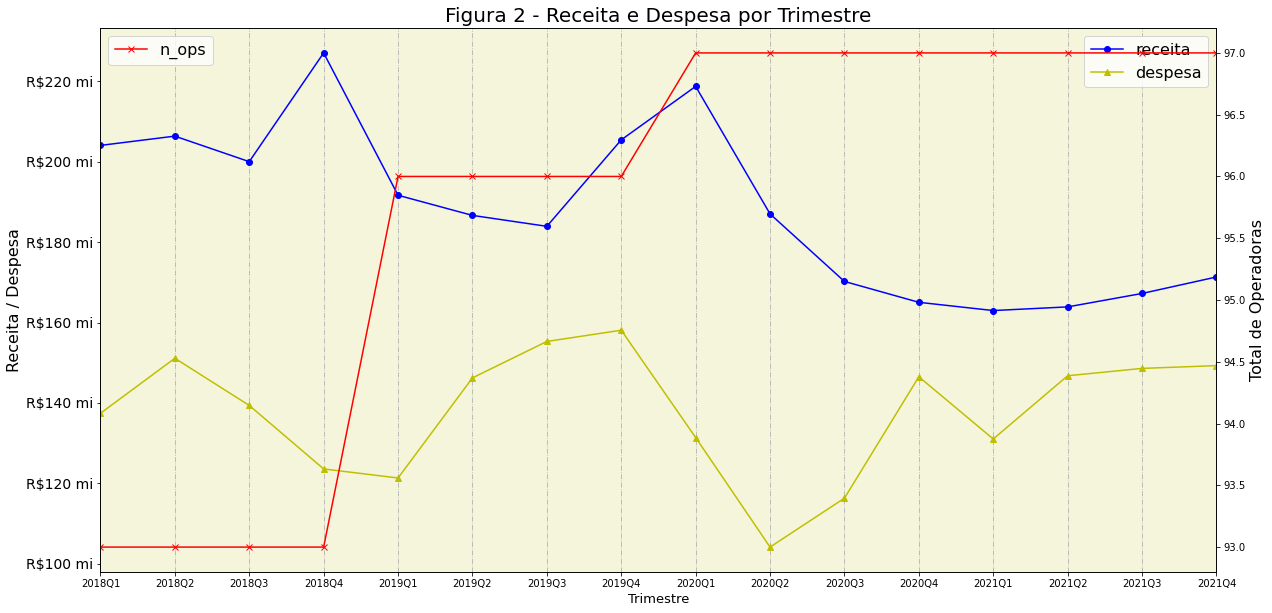

In [34]:
df_plot = ans_alterada15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('ade_p_coopmed_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

In [35]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada16.head()

,ano,cd_ops,receita,despesa
26,2018,324213,158.030,81.150
71,2018,357138,50.650,40.450
92,2018,414573,31.010,34.130
35,2018,330264,27.950,20.500
12,2018,312592,27.380,14.720


In [36]:
ans_alterada_ops = ans_alterada16.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada14.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada16 =  ans_alterada14[i1.isin(i2)]

ans_alterada16.sort_values(by=['receita'], ascending=False, inplace=True)

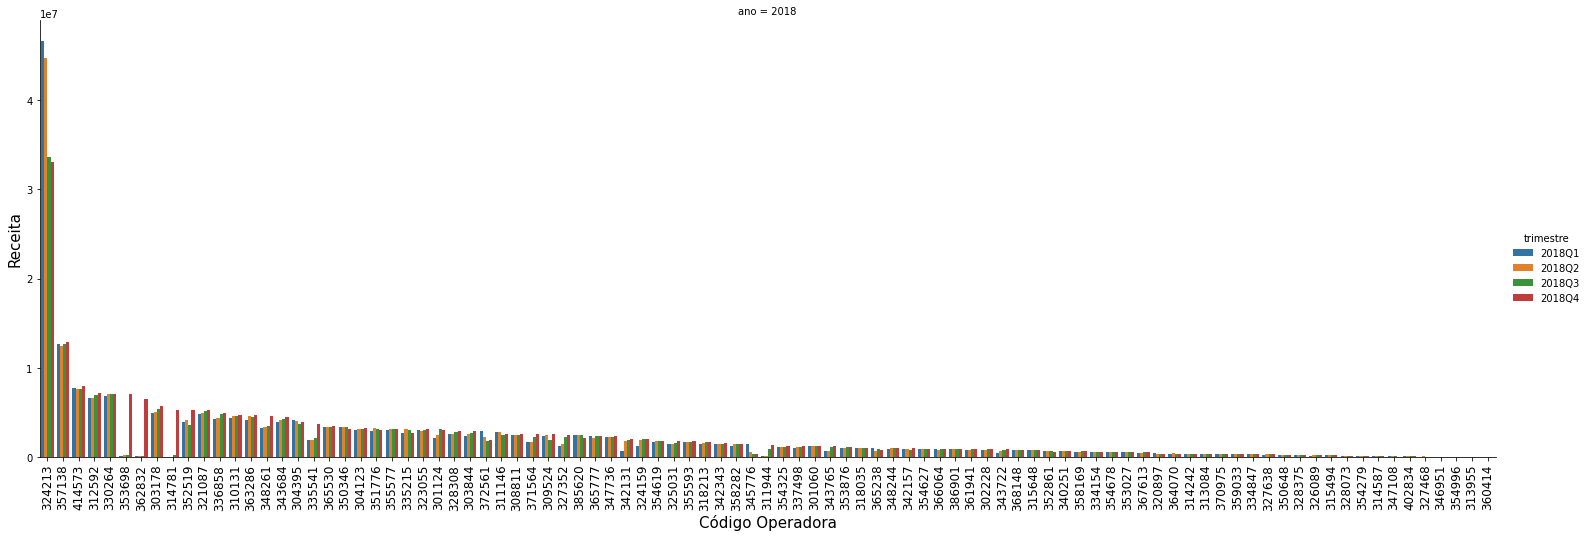

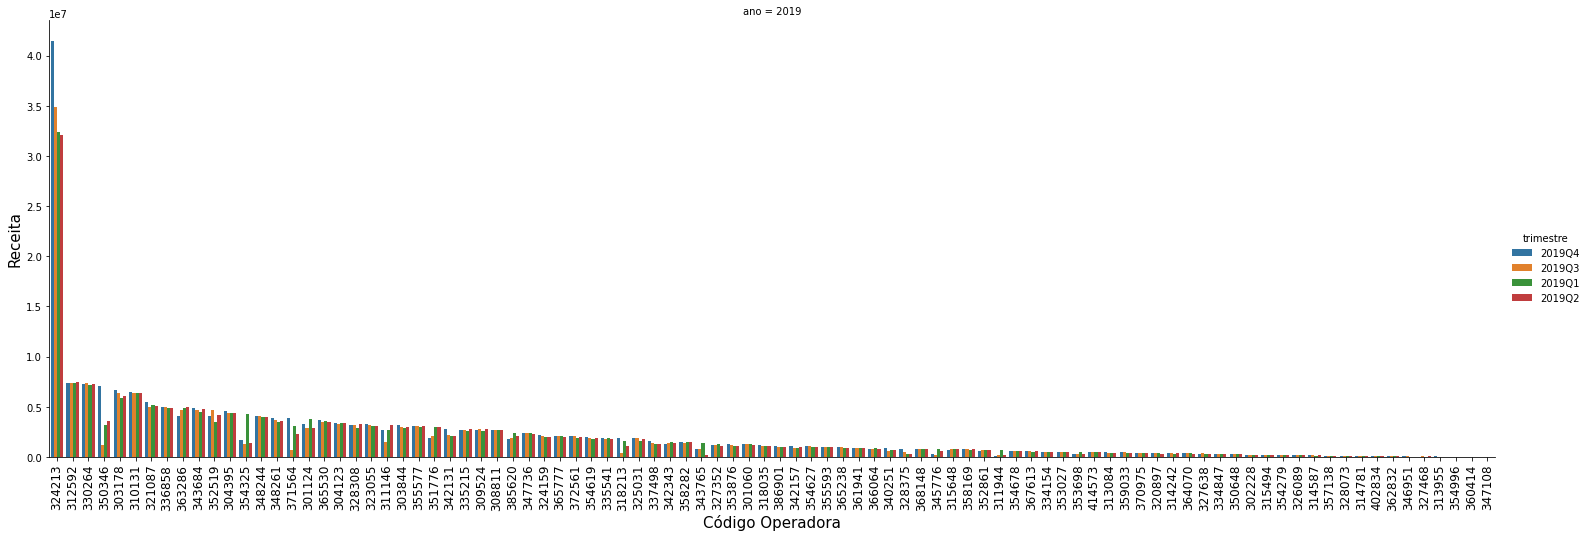

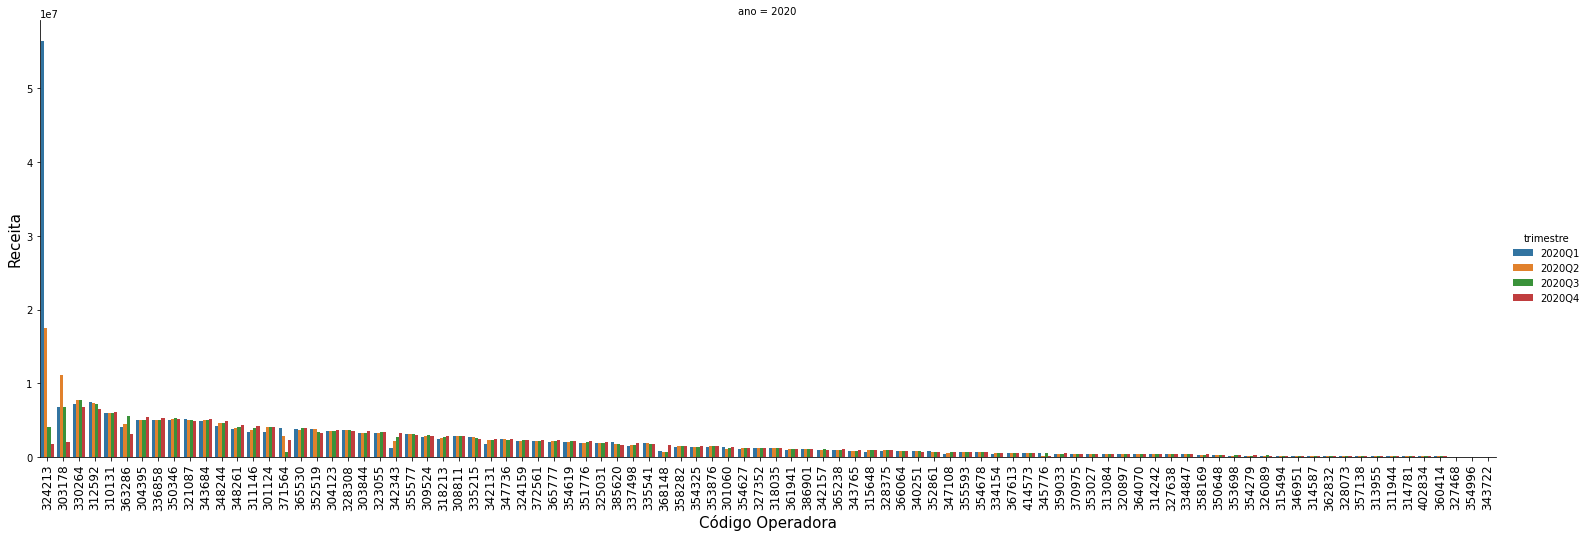

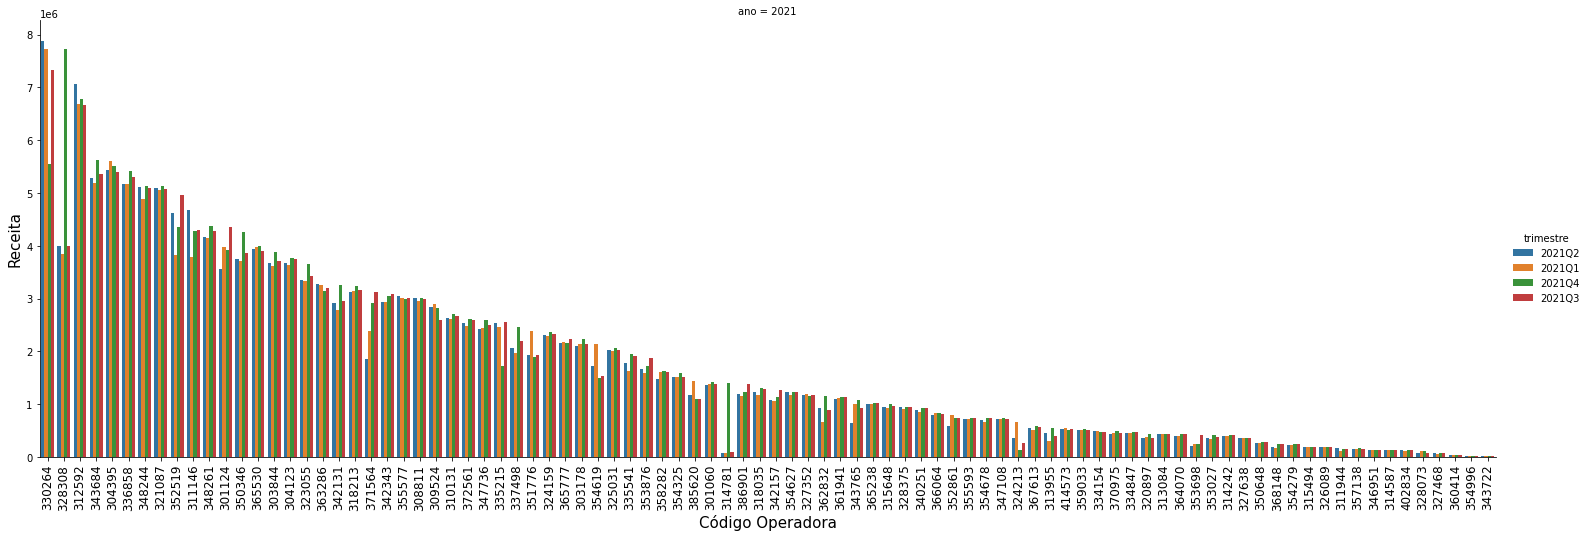

In [37]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

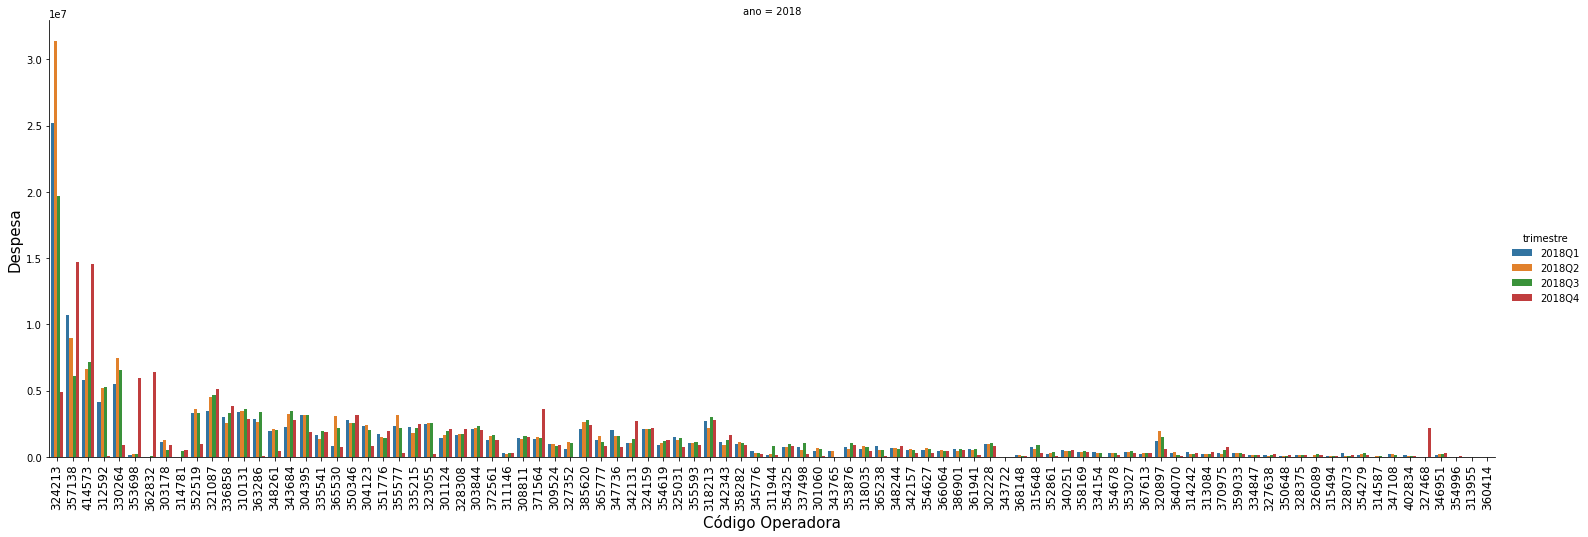

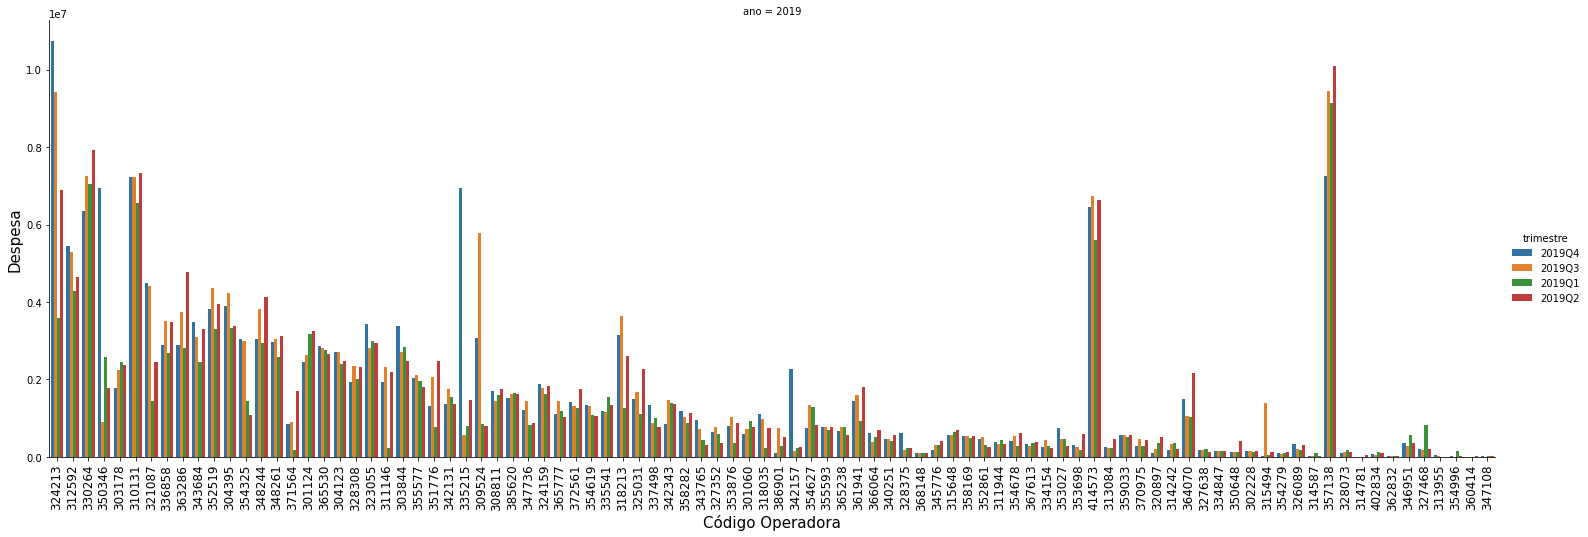

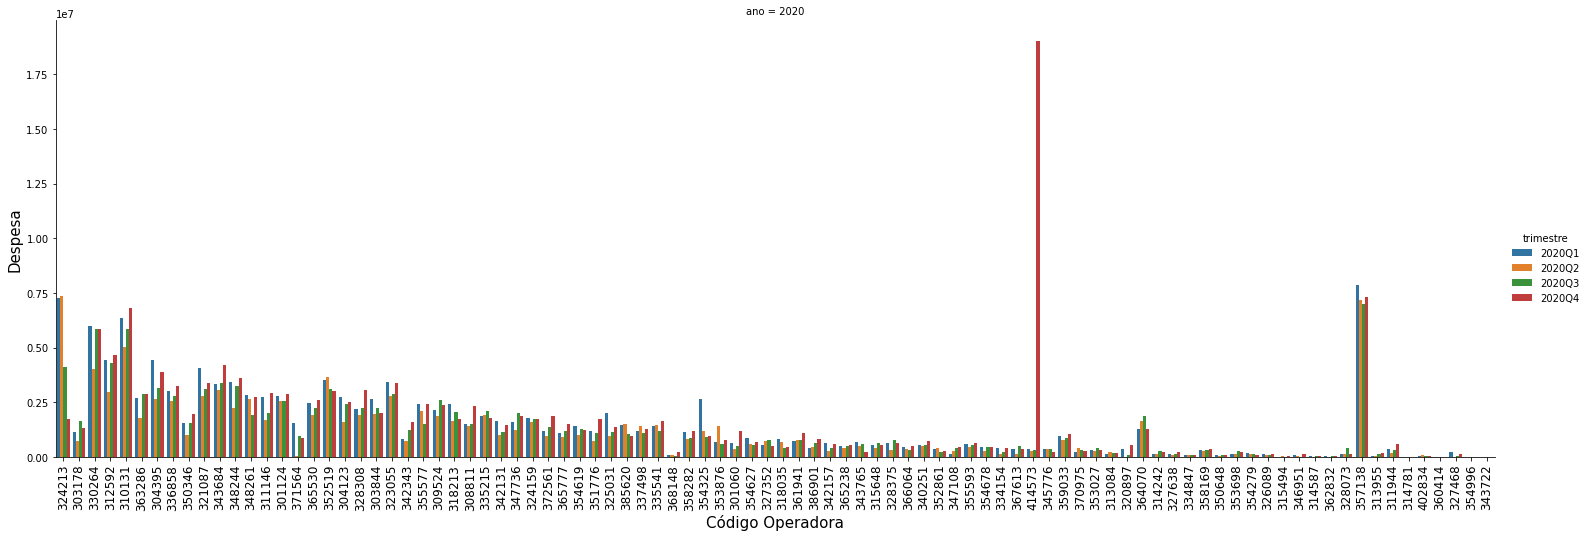

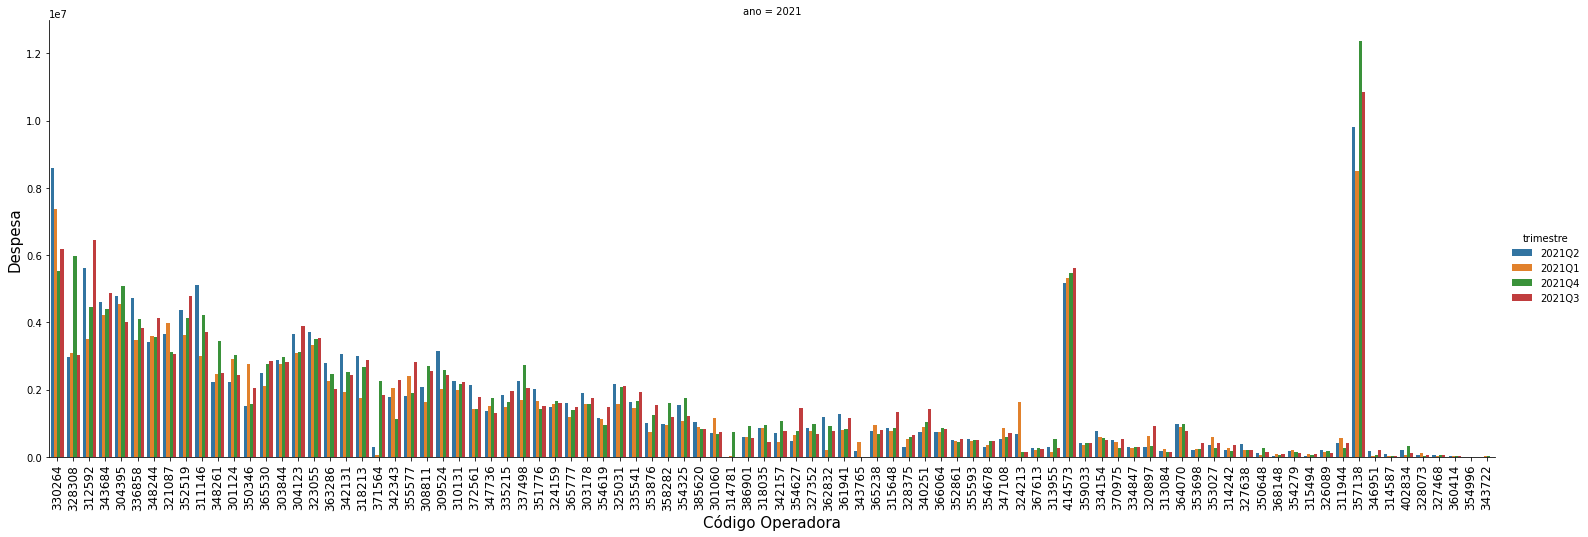

In [38]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [39]:
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg(  receita_total = ('receita','sum'),
                                                                                despesa_total = ('despesa','sum'))

ans_alterada17 = pd.merge(ans_alterada14,ans_alterada16, how='left', on=['ano','cd_ops'])

#diops_tcc_analise17 = diops_tcc_analise17[(diops_tcc_analise17['trimestre']=='2018Q4') | (diops_tcc_analise17['trimestre']=='2018Q3')]

ans_alterada17 = ans_alterada17[(ans_alterada17['ano']=='2018') | (ans_alterada17['ano']=='2020')]

ans_alterada17['pct_receita'] = ans_alterada17['receita'] / ans_alterada17['receita_total']

ans_alterada17['pct_despesa'] = ans_alterada17['despesa'] / ans_alterada17['despesa_total']

ans_alterada17.head()

,ano,cd_ops,trimestre,receita,despesa,receita_total,despesa_total,pct_receita,pct_despesa
0,2018,301060,2018Q1,1177721.040,449595.640,4777162.000,1742318.860,0.247,0.258
1,2018,301060,2018Q2,1184356.930,663144.760,4777162.000,1742318.860,0.248,0.381
2,2018,301060,2018Q3,1180727.880,568360.530,4777162.000,1742318.860,0.247,0.326
3,2018,301060,2018Q4,1234356.150,61217.930,4777162.000,1742318.860,0.258,0.035
4,2018,301124,2018Q1,2092732.850,1396791.320,10680001.310,7163246.850,0.196,0.195


In [40]:
stats_ans_alterada3 = ans_alterada17.groupby(['ano','trimestre'])[['pct_receita','pct_despesa']].describe(percentiles = [.51])

stats_ans_alterada3

pct_receita                                     pct_despesa                                    
                     count  mean   std   min   50%   51%   max       count  mean   std   min   50%   51%   max
ano  trimestre                                                                                                
2018 2018Q1         93.000 0.231 0.064 0.006 0.240 0.241 0.569      92.000 0.246 0.099 0.000 0.253 0.255 0.529
     2018Q2         93.000 0.237 0.051 0.006 0.247 0.247 0.342      92.000 0.255 0.093 0.002 0.259 0.259 0.548
     2018Q3         93.000 0.247 0.049 0.009 0.253 0.253 0.355      92.000 0.263 0.091 0.002 0.271 0.271 0.651
     2018Q4         93.000 0.285 0.130 0.076 0.259 0.260 0.973      92.000 0.236 0.188 0.000 0.229 0.233 0.988
2020 2020Q1         97.000 0.250 0.068 0.122 0.247 0.247 0.707      97.000 0.269 0.096 0.014 0.264 0.264 0.874
     2020Q2         97.000 0.245 0.033 0.057 0.248 0.248 0.418      97.000 0.198 0.071 0.006 0.206 0.206 0.412
     2020Q3         97.000 0.248 0.040 0.051 0.250 0.251 0.416      97.000 0.244 0.077 0.016 0.243 0.243 0.636
     2020Q4         97.000 0.256 0.053 0.022 0.255 0.255 0.427      97.000 0.289 0.109 0.038 0.283 0.283 0.952

In [41]:
stats_ans_alterada4 = stats_ans_alterada3.reset_index(level=[0,1])

stats_ans_alterada4.columns = ['_'.join(col) for col in stats_ans_alterada4.columns.values]

stats_ans_alterada4 = stats_ans_alterada4[['ano_','trimestre_','pct_receita_mean','pct_despesa_mean','pct_receita_50%','pct_despesa_50%','pct_receita_51%', 'pct_despesa_51%']]

stats_ans_alterada4.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_receita_50%':'pct_receita_50',
                                      'pct_despesa_50%':'pct_despesa_50',
                                      'pct_receita_51%':'pct_receita_ref',
                                      'pct_despesa_51%':'pct_despesa_ref'}, inplace = True)

stats_ans_alterada4

,ano,trimestre,pct_receita_mean,pct_despesa_mean,pct_receita_50,pct_despesa_50,pct_receita_ref,pct_despesa_ref
0,2018,2018Q1,0.231,0.246,0.240,0.253,0.241,0.255
1,2018,2018Q2,0.237,0.255,0.247,0.259,0.247,0.259
2,2018,2018Q3,0.247,0.263,0.253,0.271,0.253,0.271
3,2018,2018Q4,0.285,0.236,0.259,0.229,0.260,0.233
4,2020,2020Q1,0.250,0.269,0.247,0.264,0.247,0.264
5,2020,2020Q2,0.245,0.198,0.248,0.206,0.248,0.206
6,2020,2020Q3,0.248,0.244,0.250,0.243,0.251,0.243
7,2020,2020Q4,0.256,0.289,0.255,0.283,0.255,0.283


In [42]:
ans_alterada18 = pd.merge(ans_alterada17,stats_ans_alterada4[['ano','trimestre','pct_receita_mean','pct_despesa_mean','pct_receita_50','pct_despesa_50','pct_receita_ref','pct_despesa_ref']], how='left', on=['ano','trimestre'])

ans_alterada18['receita_mean'] = ans_alterada18['receita_total'] * ans_alterada18['pct_receita_50']

ans_alterada18['despesa_mean'] = ans_alterada18['despesa_total'] * ans_alterada18['pct_despesa_50']

ans_alterada18 = ans_alterada18[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise18[diops_tcc_analise18['cd_ops']=='300012']

ans_alterada18.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,301060,2018Q1,1148219.722,441320.009
1,2018,301060,2018Q2,1179172.994,451905.260
2,2018,301060,2018Q3,1207210.863,472437.778
3,2018,301060,2018Q4,1237262.666,399285.745
4,2018,301124,2018Q1,2567002.780,1814411.953


In [43]:
ans_alterada19 = pd.merge(ans_alterada17,stats_ans_alterada4, how='left', on=['ano','trimestre'])

ans_alterada19 = ans_alterada19[(ans_alterada19['pct_receita'] > ans_alterada19['pct_receita_50'])]

ans_alterada19 = ans_alterada19[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada19.sort_values(by=['ano'], ascending=[True], ignore_index=True, inplace=True)

ans_alterada19.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,301060,2018Q1,1177721.040,449595.640
1,2018,353876,2018Q1,1002407.180,780307.620
2,2018,353876,2018Q3,1063825.960,1061087.140
3,2018,353876,2018Q4,1085107.490,884577.940
4,2018,354279,2018Q3,145578.850,266174.970


In [44]:
ans_alterada20 = pd.merge(ans_alterada19,ans_alterada18, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada20 = ans_alterada20[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise20[diops_tcc_analise20['cd_ops']=='300012']

ans_alterada20.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,301060,2018Q1,1148219.722,441320.009
1,2018,353876,2018Q1,1001341.376,834551.623
2,2018,353876,2018Q3,1052786.469,893396.416
3,2018,353876,2018Q4,1078994.096,755063.354
4,2018,354279,2018Q3,141430.014,216065.264


In [45]:
ans_alterada21 = pd.merge(ans_alterada14,ans_alterada20, how='left', on=['ano','cd_ops','trimestre'])

#diops_tcc_analise21['receita_diff'] = (diops_tcc_analise21['receita'] - diops_tcc_analise21['receita_mean']) / 4.0

#diops_tcc_analise21['despesa_diff'] = (diops_tcc_analise21['despesa'] - diops_tcc_analise21['despesa_mean'])/ 4.0

ans_alterada21.fillna(0, inplace=True)

ans_alterada21['receita_corrigida'] = np.where(ans_alterada21['receita_mean'] == 0, ans_alterada21['receita'], ans_alterada21['receita_mean'])

ans_alterada21['despesa_corrigida'] = np.where(ans_alterada21['despesa_mean'] == 0, ans_alterada21['despesa'], ans_alterada21['despesa_mean'])

ans_alterada21['receita_diff_tri'] = (ans_alterada21['receita'] - ans_alterada21['receita_corrigida']) / 4.0

ans_alterada21['despesa_diff_tri'] = (ans_alterada21['despesa'] - ans_alterada21['despesa_corrigida']) / 4.0

#diops_tcc_analise21[diops_tcc_analise21['trimestre']=='2018Q4']

ans_alterada21.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada21.head()

,ano,cd_ops,trimestre,receita,despesa,receita_mean,despesa_mean,receita_corrigida,despesa_corrigida,receita_diff_tri,despesa_diff_tri
0,2018,301060,2018Q1,1177721.040,449595.640,1148219.722,441320.009,1148219.722,441320.009,7375.330,2068.908
253,2018,354627,2018Q2,898839.620,704861.280,891073.106,562790.136,891073.106,562790.136,1941.628,35517.786
252,2018,354627,2018Q1,859053.440,541592.910,0.000,0.000,859053.440,541592.910,0.000,0.000
251,2018,354619,2018Q4,1785300.300,1265263.660,0.000,0.000,1785300.300,1265263.660,0.000,0.000
250,2018,354619,2018Q3,1754630.880,1194623.130,0.000,0.000,1754630.880,1194623.130,0.000,0.000


In [46]:
ans_alterada22 = ans_alterada21.groupby(['ano','cd_ops'], as_index=False)[['receita_diff_tri','despesa_diff_tri']].sum()

ans_alterada22 = ans_alterada22[ans_alterada22['receita_diff_tri']!=0]

ans_alterada22.head()

,ano,cd_ops,receita_diff_tri,despesa_diff_tri
0,2018,301060,8671.313,54878.783
1,2018,301124,171549.374,128187.231
2,2018,302228,992.794,1239.382
3,2018,303178,73202.335,-128376.182
4,2018,303844,46422.307,-378.755


In [47]:
ans_alterada23 = ans_alterada21[['ano','cd_ops','trimestre','receita_corrigida','despesa_corrigida']].reset_index(drop=True)

ans_alterada23.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada23.head()

,ano,cd_ops,trimestre,receita_corrigida,despesa_corrigida
0,2018,301060,2018Q1,1148219.722,441320.009
253,2018,301060,2018Q2,1179172.994,451905.260
252,2018,301060,2018Q3,1180727.880,568360.530
251,2018,301060,2018Q4,1234356.150,61217.930
250,2018,345776,2018Q2,509233.670,291724.280


In [48]:
ans_alterada24 = pd.merge(ans_alterada23, ans_alterada22, how='left', on = ['ano','cd_ops'])

ans_alterada24.fillna(0, inplace=True)

ans_alterada24.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada24['receita'] = ans_alterada24['receita_corrigida'] + ans_alterada24['receita_diff_tri']

ans_alterada24['despesa'] = ans_alterada24['despesa_corrigida'] + ans_alterada24['despesa_diff_tri']

ans_alterada24 = ans_alterada24[['ano','cd_ops','trimestre','receita','despesa']]

#ans_alterada24[ans_alterada24['cd_ops']=='342084']

ans_alterada24.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,301060,2018Q1,1156891.035,496198.792
253,2018,353698,2018Q4,3241170.674,2593369.787
252,2018,345776,2018Q3,487589.249,325089.268
251,2018,354627,2018Q2,894230.828,557748.128
250,2018,354627,2018Q1,862211.162,536550.902


In [49]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\TCC\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [50]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [51]:
filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [52]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.500,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.667,4,3


In [53]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

sib_filtrada = sib_filtrada[(sib_filtrada['contratacao'] == tipo_contratacao)].reset_index(drop=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','trimestre','benef']]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','trimestre'],as_index=False).agg({'benef':'sum'})

sib_filtrada

,ano,cd_ops,trimestre,benef
0,2017,27,2017Q3,11173
1,2017,27,2017Q4,10584
2,2017,300012,2017Q3,747
3,2017,300012,2017Q4,719
4,2017,300713,2017Q3,3410
...,...,...,...,...
10227,2022,422771,2022Q1,462
10228,2022,422827,2022Q1,33
10229,2022,5711,2022Q1,116492
10230,2022,6246,2022Q1,228443


In [54]:
ans_alterada25 = pd.merge(ans_alterada24,sib_filtrada, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25['modalidade'] = tipo_modalidade

ans_alterada25['port_ops'] = porte_operadora

ans_alterada25['contratacao'] = tipo_contratacao

ans_alterada25.to_csv('ade_p_coopmed.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2018,301060,2018Q1,1156891.035,496198.792,1022.000
1,2018,353698,2018Q4,3241170.674,2593369.787,267.000
2,2018,345776,2018Q3,487589.249,325089.268,570.000
3,2018,354627,2018Q2,894230.828,557748.128,1097.000
4,2018,354627,2018Q1,862211.162,536550.902,1080.000


In [55]:
ans_alterada26 = ans_alterada25.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_million(x),
                                                                                    'despesa':lambda x: sum_million(x),
                                                                                    'benef': 'sum',
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada26['pct_despesa'] = ans_alterada26.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada26.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_alterada26 = ans_alterada26[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_alterada26.to_csv('ade_p_coopmed_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada26.set_index('trimestre', inplace=True)

ans_alterada26 

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,202.280,139.140,175580.000,93,68.790
2018Q2,209.650,144.800,174335.000,93,69.070
2018Q3,208.410,144.870,171939.000,93,69.510
2018Q4,217.180,122.680,167446.000,93,56.490
2019Q1,191.660,121.330,173172.000,96,63.300
2019Q2,186.650,146.230,180582.000,96,78.340
2019Q3,183.930,155.290,190092.000,96,84.430
2019Q4,205.440,158.090,194681.000,96,76.950
2020Q1,192.100,131.210,188904.000,97,68.300


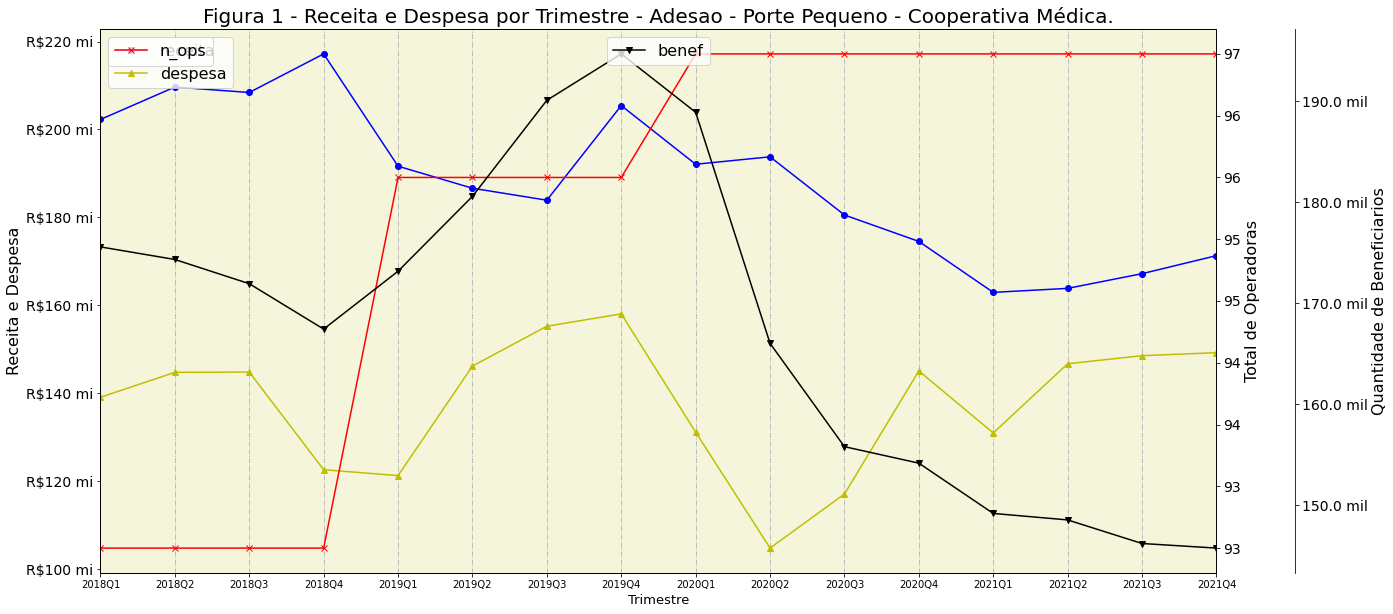

In [56]:
df_plot = ans_alterada26.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesao - Porte Pequeno - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x/1) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mil'.format(x/1e3) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.savefig('ade_p_coopmed_02.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [57]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada27 = ans_alterada25.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada27.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada27.head()

,ano,cd_ops,receita,despesa
26,2018,324213,158.030,81.150
71,2018,357138,50.650,40.450
92,2018,414573,31.010,34.130
35,2018,330264,27.950,20.500
12,2018,312592,27.380,14.720


In [58]:
ans_alterada_ops = ans_alterada27.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada25.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada28 =  ans_alterada25[i1.isin(i2)]

ans_alterada28.sort_values(by=['receita'], ascending=False, inplace=True)

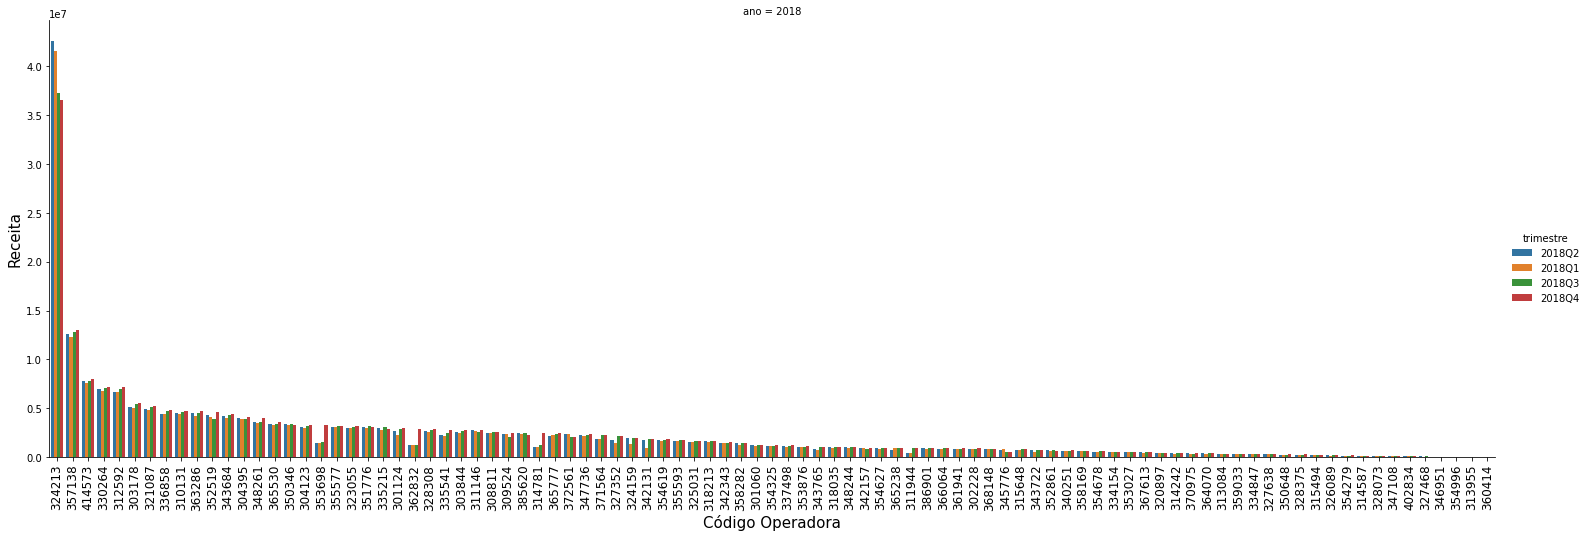

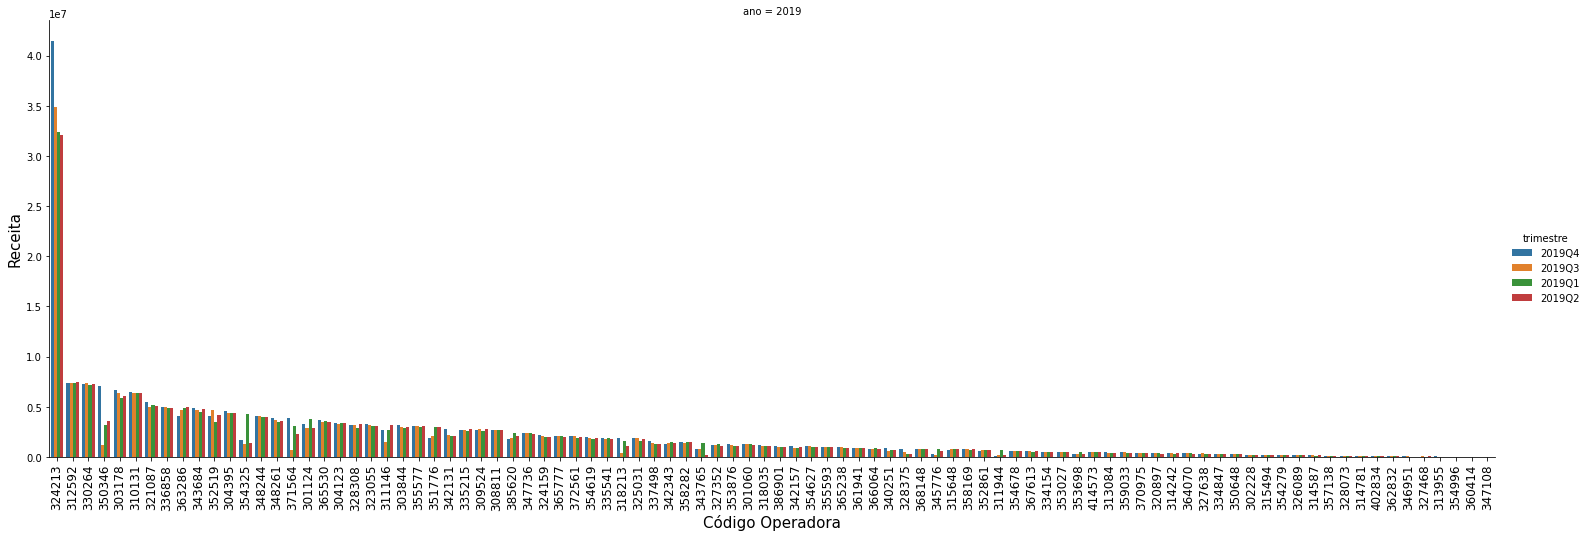

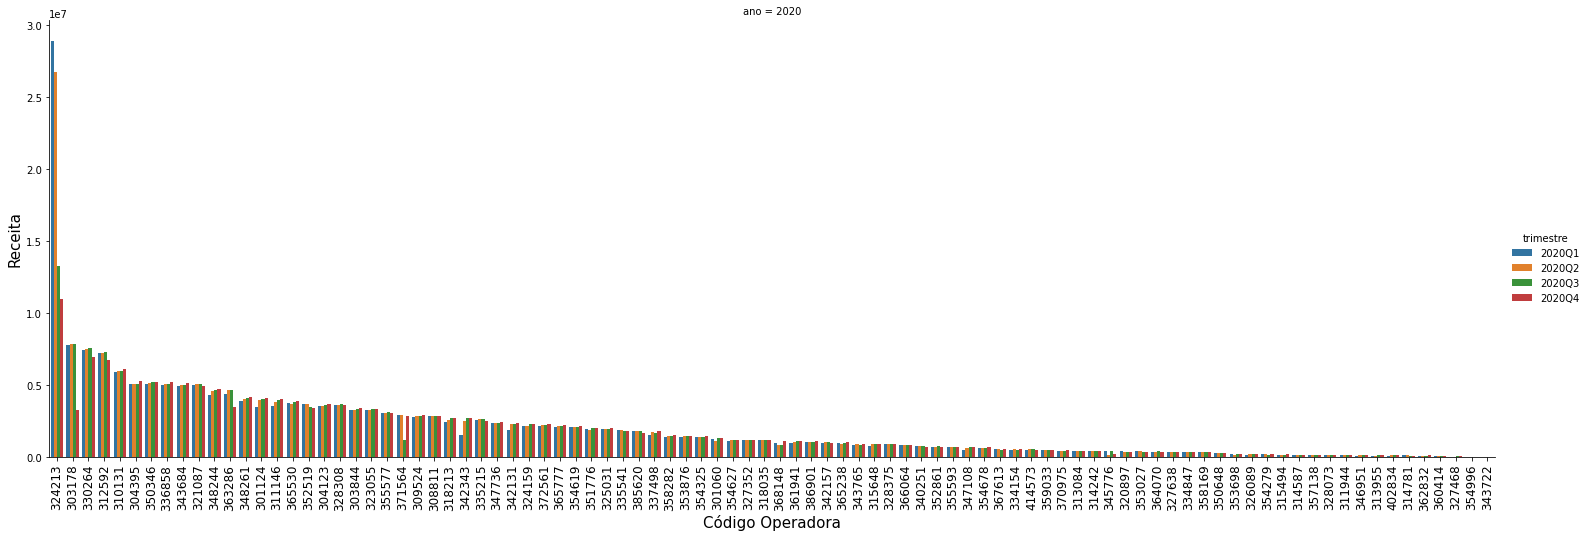

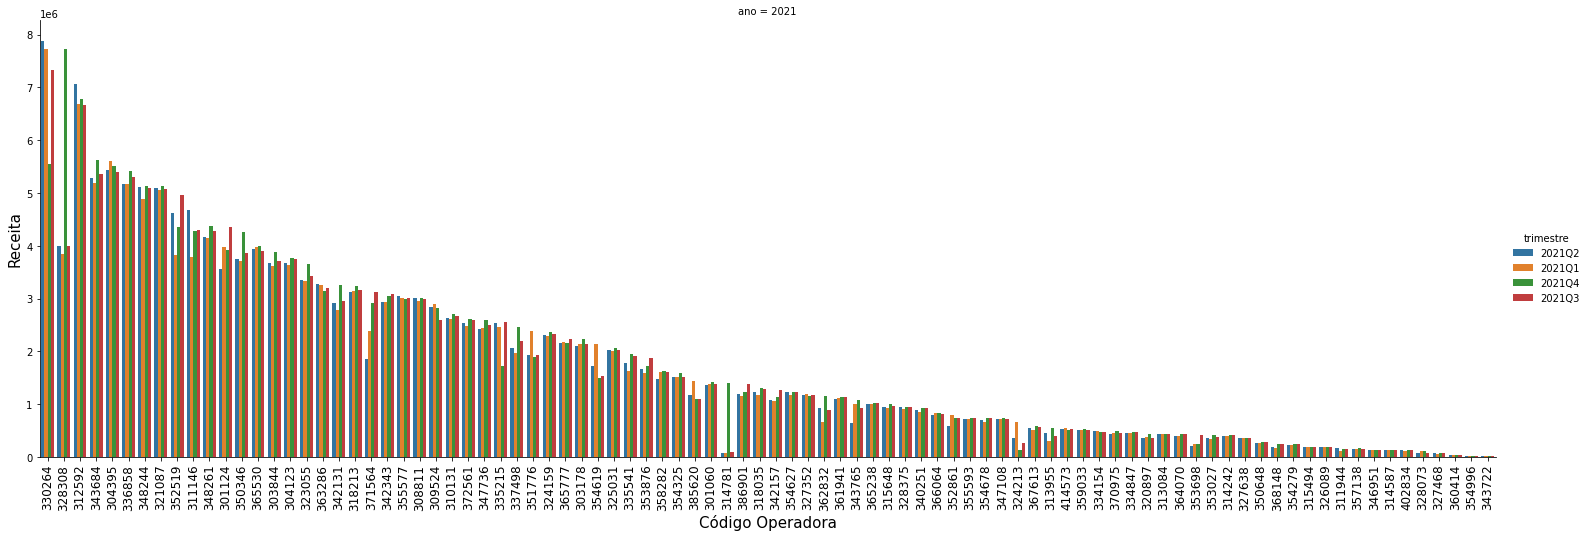

In [59]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

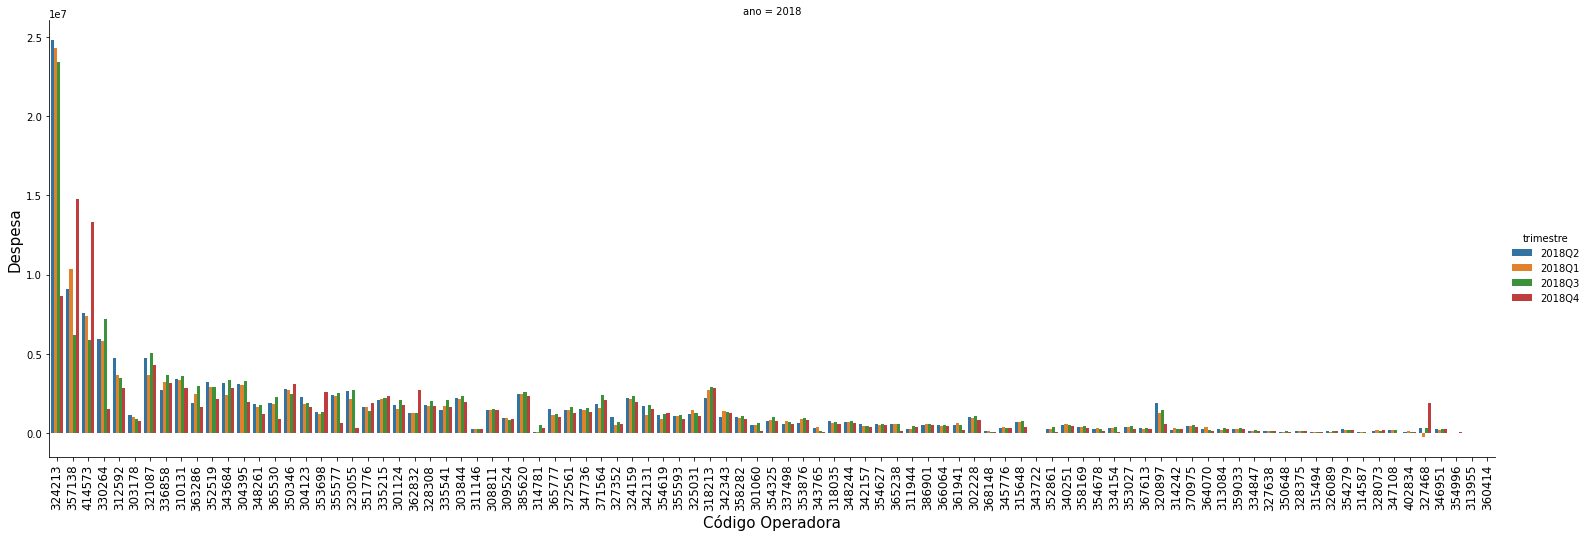

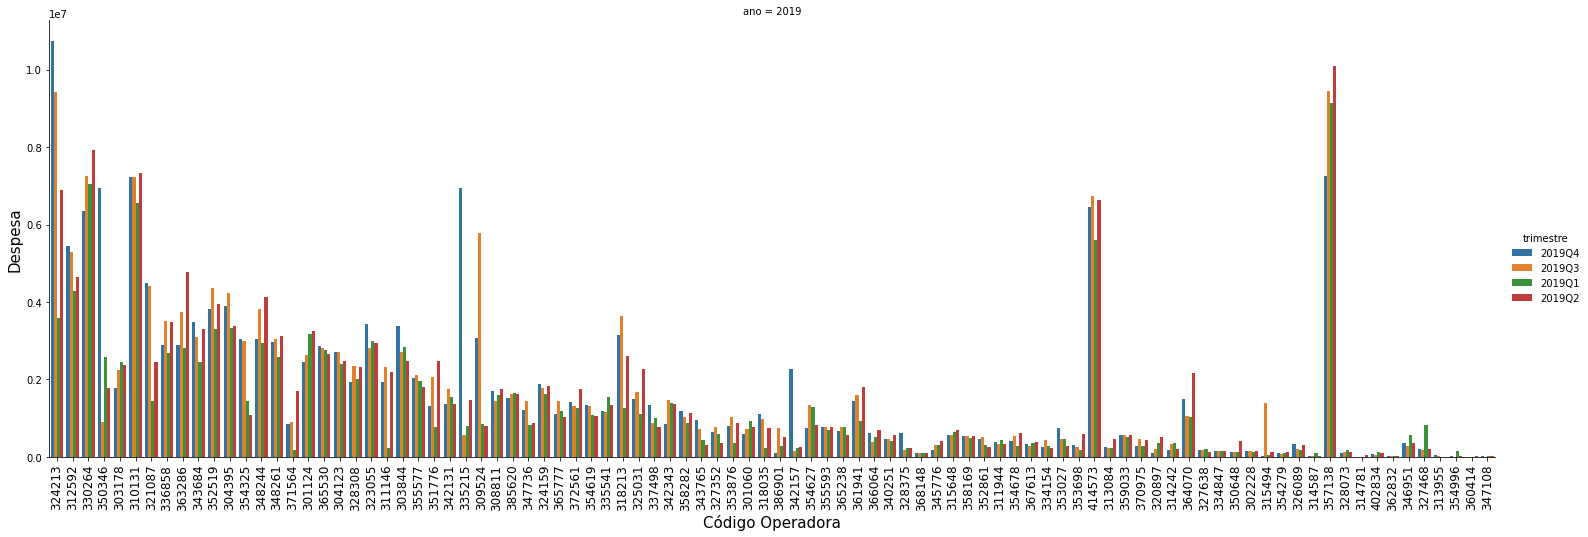

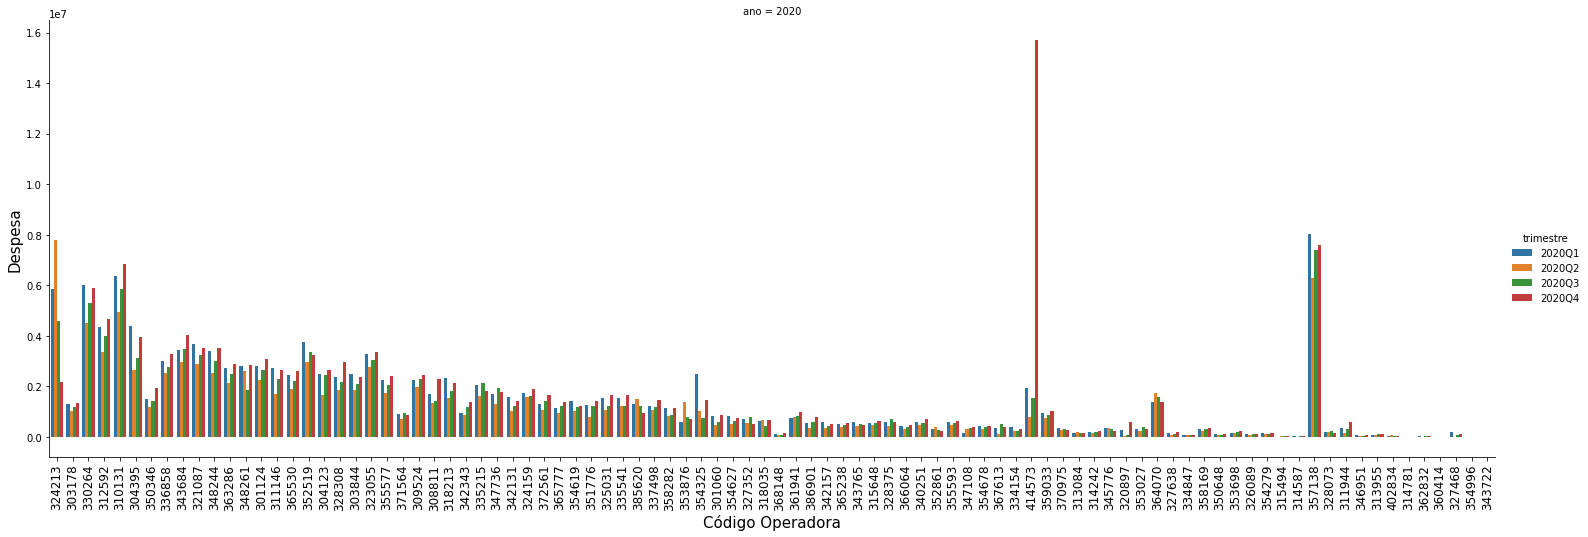

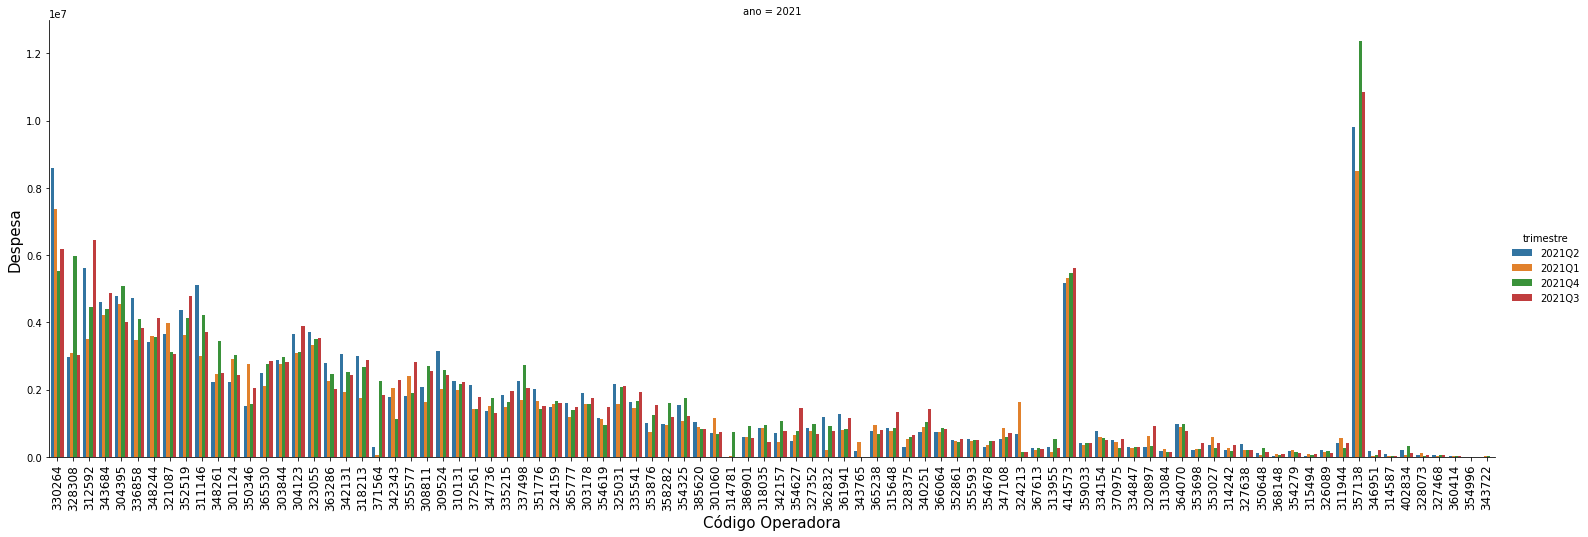

In [60]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()